## Regresion y Clasificación

### Configuración y librerias 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from varclushi import VarClusHi
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

In [16]:
sns.set_theme(style='darkgrid')

In [3]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.6f}'.format

In [12]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Extraccion de datos

In [5]:
ruta = '../data/estaciones'
lst_files = os.listdir( ruta )
lst_files

['estaciones.csv']

In [6]:
file = [ a for a in  lst_files if a[-3:] == 'csv']
df = pd.read_csv( os.path.join( ruta , file[0]  ) , sep='|' )
df.sample(10)

,afluencia,id_estacion,t
204426,140569,Est00039,143
175581,405,Est00082,333
111477,37236,Est00204,483
268032,405,Est00292,126
214397,62439,Est00070,59
149111,12245,Est00002,565
214977,79882,Est00208,349
91978,405,Est00129,523
25683,35489,Est00118,88
224965,77984,Est00092,198


## Planteamiento del problema

Resolver la problematica para todas las estaciones a nivel nacional:
- Pronosticar la afluencia de cualquier estación.
- Identificar si alguna estación será de alta demanda o no (0 = Baja demanda, 1 = Alta demanda)

Las dos problematicas son de tipo MODELOS SUPERVISADOS:
1. Es un modelo de regressión.
2. Es un modelo de clasificación.

## Limpieza / Exploración

In [7]:
df.dtypes

afluencia       int64
id_estacion    object
t               int64
dtype: object

In [8]:
# Unidad muestral
um = ['id_estacion']

t_min = df['t'].min()
t_max = df['t'].max()
cols = range( t_min, t_max )

t_min, t_max

(np.int64(1), np.int64(700))

In [9]:
df.pivot_table( index=um, columns='t', values='afluencia', aggfunc='sum' ).reset_index()

t,id_estacion,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700
0,Est00000,"39,059.000000","74,700.000000","44,356.000000","237,597.000000","235,918.000000","181,140.000000","257,563.000000","257,761.000000","142,208.000000","68,416.000000","233,986.000000","297,135.000000","244,377.000000","213,395.000000","284,806.000000","191,722.000000","90,565.000000","284,391.000000","286,159.000000","265,663.000000","308,424.000000","278,298.000000","145,315.000000","114,979.000000","246,934.000000","196,434.000000","282,779.000000","257,312.000000","337,761.000000","193,769.000000","72,877.000000","99,671.000000","257,584.000000","334,456.000000","249,029.000000","309,451.000000","208,369.000000","82,072.000000","263,976.000000","347,139.000000","247,580.000000","319,318.000000","353,565.000000","146,118.000000","99,440.000000","365,255.000000","295,789.000000","267,934.000000","276,156.000000","332,286.000000","175,394.000000","88,614.000000","284,173.000000","327,866.000000","311,287.000000","295,959.000000","307,444.000000","214,789.000000","77,474.000000","305,030.000000","324,704.000000","319,114.000000","247,539.000000","338,883.000000","213,442.000000","185,771.000000","243,337.000000","320,875.000000","318,869.000000","286,057.000000","363,643.000000","167,600.000000","87,362.000000","95,040.000000","323,697.000000","290,205.000000","264,629.000000","329,988.000000","236,047.000000","78,726.000000","292,014.000000","320,433.000000","281,786.000000","349,471.000000","317,400.000000","163,575.000000","91,647.000000","243,928.000000","261,433.000000","234,279.000000","93,755.000000","59,963.000000","71,592.000000","58,882.000000","257,108.000000","297,897.000000","279,338.000000","288,716.000000","389,220.000000",...,"303,663.000000","295,040.000000","311,083.000000","241,154.000000","126,852.000000","384,364.000000","338,148.000000","360,263.000000","350,722.000000","323,956.000000","247,016.000000","107,879.000000","400,046.000000","322,548.000000","300,957.000000","295,217.000000","319,998.000000","242,201.000000","114,897.000000","389,940.000000","316,448.000000","312,626.000000","328,689.000000","98,454.000000","160,555.000000","97,413.000000","408,247.000000","335,122.000000","310,403.000000","301,861.000000","313,633.000000","246,601.000000","111,735.000000","386,295.000000","321,814.000000","319,366.000000","322,807.000000","364,452.000000","267,397.000000","126,036.000000","419,842.000000","339,712.000000","312,511.000000","289,770.000000","318,366.000000","235,299.000000","118,678.000000","389,281.000000","314,837.000000","295,857.000000","301,889.000000","369,308.000000","271,865.000000","123,949.000000","424,303.000000","328,247.000000","308,635.000000","297,251.000000","308,274.000000","236,271.000000","106,873.000000","387,071.000000","332,824.000000","309,247.000000","313,830.000000","354,558.000000","247,682.000000","115,516.000000","405,568.000000","315,027.000000","159,651.000000","329,464.000000","321,943.000000","222,915.000000","113,659.000000","379,849.000000","320,937.000000","309,172.000000","297,774.000000","320,161.000000","238,135.000000","122,480.000000","414,973.000000","396,088.000000","373,579.000000","336,115.000000","329,641.000000","248,852.000000","112,633.000000","139,188.000000","370,097.000000","305,425.000000","311,695.000000","325,139.000000","240,916.000000","1

### Funciones

Importar funciones de `agg_func.py` from `scratch`

In [3]:
from scratch.agg_func import *

In [11]:
lst_func = [ 'sum','min','mean','max','std', 
            sum_inc , sum_dec ,  media_inc, media_dec,
            delta_min, delta_max, delta_mean, delta_desv,
            pct_delta_min, pct_delta_max, pct_delta_mean, pct_delta_desv,
            max_racha_inc, max_racha_dec, media_racha_inc, media_racha_dec ]

## Ventanas de tiempo

In [12]:
window_slide = 1  # numero de dezplazamientos
window_len   = 10 # tamaño de la ventana

ancla_inicio = t_min + window_len - 1
ancla_final  = t_max - window_slide

In [13]:
print( "Ventanas: ", window_slide , " ---  ", window_len )
print( "Anclas:  ", ancla_inicio, " --- ", ancla_final )

Ventanas:  1  ---   10
Anclas:   10  ---  699


## Matriz de predictoras

In [14]:
lst_aux = []

for ancla_loop in range( ancla_inicio, ancla_final + 1 ):
    
    # print( ancla_loop )
    print( "Intervalo: ", ancla_loop - ancla_inicio, ancla_loop, " para pronosticar: ", ancla_loop + window_slide )

    # get interval of rows between two intervals of the loop
    aux = df[ ( df['t'] > ancla_loop - ancla_inicio ) & 
              ( df['t'] <= ancla_loop ) ].reset_index(drop=True)
    
    # compute pivot_table (aggfunc in lst) by each 'id_estacion' using 'afluencia' as values
    aux = aux.pivot_table(
        index = um,
        values = 'afluencia',
        aggfunc = lst_func
    )

    # rename columns 
    aux.columns = [f"v_{i}_{j}" for i,j in aux.columns]

    # add value on index as 'ancla'
    aux.insert( 0, 'ancla', ancla_loop )
    aux.reset_index( inplace=True )
    # print( f"Tamaño del DataFrame { aux.shape } - { ancla_loop }")

    lst_aux.append( aux )

Intervalo:  0 10  para pronosticar:  11
Intervalo:  1 11  para pronosticar:  12
Intervalo:  2 12  para pronosticar:  13
Intervalo:  3 13  para pronosticar:  14
Intervalo:  4 14  para pronosticar:  15
Intervalo:  5 15  para pronosticar:  16
Intervalo:  6 16  para pronosticar:  17
Intervalo:  7 17  para pronosticar:  18
Intervalo:  8 18  para pronosticar:  19
Intervalo:  9 19  para pronosticar:  20
Intervalo:  10 20  para pronosticar:  21
Intervalo:  11 21  para pronosticar:  22
Intervalo:  12 22  para pronosticar:  23
Intervalo:  13 23  para pronosticar:  24
Intervalo:  14 24  para pronosticar:  25
Intervalo:  15 25  para pronosticar:  26
Intervalo:  16 26  para pronosticar:  27
Intervalo:  17 27  para pronosticar:  28
Intervalo:  18 28  para pronosticar:  29
Intervalo:  19 29  para pronosticar:  30
Intervalo:  20 30  para pronosticar:  31
Intervalo:  21 31  para pronosticar:  32
Intervalo:  22 32  para pronosticar:  33
Intervalo:  23 33  para pronosticar:  34
Intervalo:  24 34  para pr

In [15]:
X = pd.concat( lst_aux  , ignore_index=True)
X

,id_estacion,ancla,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_media_inc_afluencia,v_media_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_min_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,v_max_racha_inc_afluencia,v_max_racha_dec_afluencia,v_media_racha_inc_afluencia,v_media_racha_dec_afluencia
0,Est00000,10,1538718,39059,"153,871.800000",257761,"91,233.811354",5,4,0.555556,0.444444,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",-0.827786,3.083777,0.545427,1.235866,2,2,1.000000,0.666667
1,Est00001,10,2358299,48321,"235,829.900000",368193,"106,206.846405",3,6,0.333333,0.666667,"-319,872.000000","253,813.000000",-173.111111,"187,447.334079",-0.868762,5.074171,0.709150,1.807480,1,3,0.428571,1.500000
2,Est00002,10,375640,17515,"37,564.000000",54652,"12,687.905685",3,6,0.333333,0.666667,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",-0.522402,1.464516,0.152796,0.641499,1,3,0.428571,1.500000
3,Est00003,10,1760254,40677,"176,025.400000",253680,"71,681.461608",7,2,0.777778,0.222222,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",-0.831095,4.357573,0.549353,1.442348,3,1,2.333333,0.250000
4,Est00004,10,1938085,82758,"193,808.500000",255863,"53,239.580955",4,5,0.444444,0.555556,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",-0.532240,0.970951,0.074904,0.407847,2,3,0.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269095,Est00385,699,4050,405,405.000000,405,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
269096,Est00386,699,612947,38902,"61,294.700000",71912,"11,646.379953",5,4,0.555556,0.444444,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",-0.443016,0.652917,0.068500,0.370158,3,2,1.000000,0.666667
269097,Est00387,699,2885651,269899,"288,565.100000",336441,"20,369.570614",5,4,0.555556,0.444444,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",-0.117212,0.235244,0.015126,0.090890,3,3,1.000000,0.666667
269098,Est00388,699,2310010,140453,"231,001.000000",280277,"47,489.221879",6,3,0.666667,0.333333,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",-0.413660,0.842809,0.116281,0.350651,3,1,1.500000,0.428571


## Vector Solución

In [16]:
lst_aux = []

for ancla_loop in range( ancla_inicio, ancla_final + 1 ):

    print( "Intervalo: ", ancla_loop - ancla_inicio, ancla_loop, " para pronosticar: ", ancla_loop + window_slide)

    # get interval of rows between two intervals of the loop
    aux = df[ ( df['t'] > ancla_loop - ancla_inicio ) & 
              ( df['t'] <= ancla_loop + window_slide) ].reset_index(drop=True)
    
    # display(aux[aux['id_estacion'] == 'Est00000'].sort_values(by='t'))
    # display( aux )

    aux = aux.pivot_table( index=um, columns='t', values='afluencia' )
    # display( aux )

    aux['y'] = aux[ ancla_loop + window_slide ]
    # display( aux )

    aux = aux[['y']]
    # display( aux )

    aux.insert( 0, 'ancla', ancla_loop )
    # display( aux )

    aux.reset_index(inplace=True)

    lst_aux.append( aux )

Intervalo:  0 10  para pronosticar:  11
Intervalo:  1 11  para pronosticar:  12
Intervalo:  2 12  para pronosticar:  13
Intervalo:  3 13  para pronosticar:  14
Intervalo:  4 14  para pronosticar:  15
Intervalo:  5 15  para pronosticar:  16
Intervalo:  6 16  para pronosticar:  17
Intervalo:  7 17  para pronosticar:  18
Intervalo:  8 18  para pronosticar:  19
Intervalo:  9 19  para pronosticar:  20
Intervalo:  10 20  para pronosticar:  21
Intervalo:  11 21  para pronosticar:  22
Intervalo:  12 22  para pronosticar:  23
Intervalo:  13 23  para pronosticar:  24
Intervalo:  14 24  para pronosticar:  25
Intervalo:  15 25  para pronosticar:  26
Intervalo:  16 26  para pronosticar:  27
Intervalo:  17 27  para pronosticar:  28
Intervalo:  18 28  para pronosticar:  29
Intervalo:  19 29  para pronosticar:  30
Intervalo:  20 30  para pronosticar:  31
Intervalo:  21 31  para pronosticar:  32
Intervalo:  22 32  para pronosticar:  33
Intervalo:  23 33  para pronosticar:  34
Intervalo:  24 34  para pr

In [17]:
y = pd.concat( lst_aux, ignore_index=True )
y

t,id_estacion,ancla,y
0,Est00000,10,"233,986.000000"
1,Est00001,10,"290,042.000000"
2,Est00002,10,"40,779.000000"
3,Est00003,10,"232,123.000000"
4,Est00004,10,"228,464.000000"
...,...,...,...
269095,Est00385,699,405.000000
269096,Est00386,699,"64,261.000000"
269097,Est00387,699,NaN
269098,Est00388,699,"266,479.000000"


In [18]:
X.shape, y.shape

((269100, 23), (269100, 3))

## TAD preeliminar

In [19]:
tad = X.merge( y, on=['id_estacion', 'ancla'], how='inner' )
tad

,id_estacion,ancla,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_media_inc_afluencia,v_media_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_min_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,v_max_racha_inc_afluencia,v_max_racha_dec_afluencia,v_media_racha_inc_afluencia,v_media_racha_dec_afluencia,y
0,Est00000,10,1538718,39059,"153,871.800000",257761,"91,233.811354",5,4,0.555556,0.444444,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",-0.827786,3.083777,0.545427,1.235866,2,2,1.000000,0.666667,"233,986.000000"
1,Est00001,10,2358299,48321,"235,829.900000",368193,"106,206.846405",3,6,0.333333,0.666667,"-319,872.000000","253,813.000000",-173.111111,"187,447.334079",-0.868762,5.074171,0.709150,1.807480,1,3,0.428571,1.500000,"290,042.000000"
2,Est00002,10,375640,17515,"37,564.000000",54652,"12,687.905685",3,6,0.333333,0.666667,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",-0.522402,1.464516,0.152796,0.641499,1,3,0.428571,1.500000,"40,779.000000"
3,Est00003,10,1760254,40677,"176,025.400000",253680,"71,681.461608",7,2,0.777778,0.222222,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",-0.831095,4.357573,0.549353,1.442348,3,1,2.333333,0.250000,"232,123.000000"
4,Est00004,10,1938085,82758,"193,808.500000",255863,"53,239.580955",4,5,0.444444,0.555556,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",-0.532240,0.970951,0.074904,0.407847,2,3,0.666667,1.000000,"228,464.000000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269095,Est00385,699,4050,405,405.000000,405,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,405.000000
269096,Est00386,699,612947,38902,"61,294.700000",71912,"11,646.379953",5,4,0.555556,0.444444,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",-0.443016,0.652917,0.068500,0.370158,3,2,1.000000,0.666667,"64,261.000000"
269097,Est00387,699,2885651,269899,"288,565.100000",336441,"20,369.570614",5,4,0.555556,0.444444,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",-0.117212,0.235244,0.015126,0.090890,3,3,1.000000,0.666667,NaN
269098,Est00388,699,2310010,140453,"231,001.000000",280277,"47,489.221879",6,3,0.666667,0.333333,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",-0.413660,0.842809,0.116281,0.350651,3,1,1.500000,0.428571,"266,479.000000"


<Axes: >

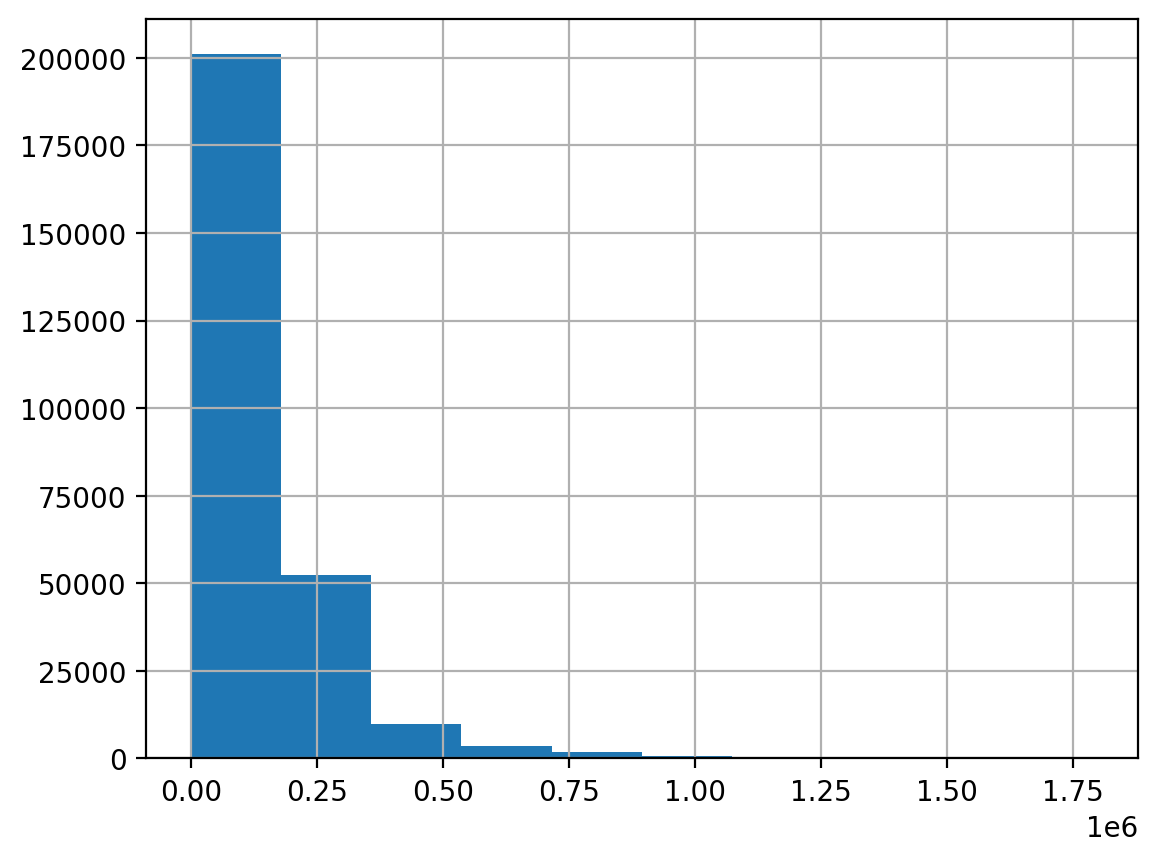

In [20]:
tad['y'].hist()

In [21]:
tad['y2'] = np.where( tad['y'] <= 10000, 0, 1 )

In [22]:
tad['y'].describe(percentiles=np.arange(0, 1.01, 0.1))

count     268,977.000000
mean      135,353.796012
std       132,691.970460
min           405.000000
0%            405.000000
10%        20,378.000000
20%        40,480.000000
30%        56,325.000000
40%        75,727.000000
50%        99,644.000000
60%       128,416.000000
70%       161,582.000000
80%       202,716.600000
90%       282,528.000000
100%    1,789,298.000000
max     1,789,298.000000
Name: y, dtype: float64

[]

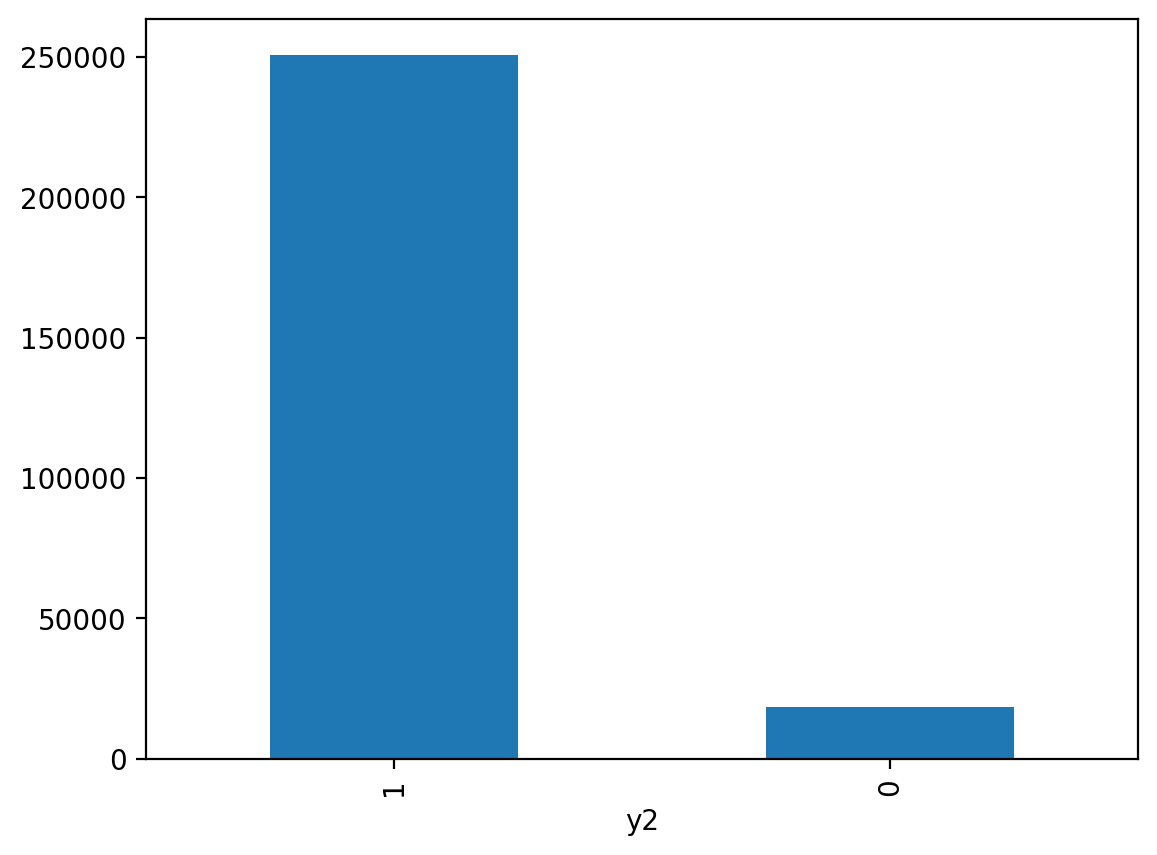

In [23]:
tad['y2'].value_counts().plot(kind='bar')
plt.plot()

### Persistir TAD

In [24]:
tad.to_parquet('../data/output/tad_preeliminar_estaciones.parquet')

## Análisis Exploratorio

### Variables Continuas / Numericas

In [25]:
cols_cont = tad.filter(like='v_').columns.to_list()
cols_cont

['v_sum_afluencia',
 'v_min_afluencia',
 'v_mean_afluencia',
 'v_max_afluencia',
 'v_std_afluencia',
 'v_sum_inc_afluencia',
 'v_sum_dec_afluencia',
 'v_media_inc_afluencia',
 'v_media_dec_afluencia',
 'v_delta_min_afluencia',
 'v_delta_max_afluencia',
 'v_delta_mean_afluencia',
 'v_delta_desv_afluencia',
 'v_pct_delta_min_afluencia',
 'v_pct_delta_max_afluencia',
 'v_pct_delta_mean_afluencia',
 'v_pct_delta_desv_afluencia',
 'v_max_racha_inc_afluencia',
 'v_max_racha_dec_afluencia',
 'v_media_racha_inc_afluencia',
 'v_media_racha_dec_afluencia']

In [26]:
X = tad[ cols_cont ]
X

,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_media_inc_afluencia,v_media_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_min_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,v_max_racha_inc_afluencia,v_max_racha_dec_afluencia,v_media_racha_inc_afluencia,v_media_racha_dec_afluencia
0,1538718,39059,"153,871.800000",257761,"91,233.811354",5,4,0.555556,0.444444,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",-0.827786,3.083777,0.545427,1.235866,2,2,1.000000,0.666667
1,2358299,48321,"235,829.900000",368193,"106,206.846405",3,6,0.333333,0.666667,"-319,872.000000","253,813.000000",-173.111111,"187,447.334079",-0.868762,5.074171,0.709150,1.807480,1,3,0.428571,1.500000
2,375640,17515,"37,564.000000",54652,"12,687.905685",3,6,0.333333,0.666667,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",-0.522402,1.464516,0.152796,0.641499,1,3,0.428571,1.500000
3,1760254,40677,"176,025.400000",253680,"71,681.461608",7,2,0.777778,0.222222,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",-0.831095,4.357573,0.549353,1.442348,3,1,2.333333,0.250000
4,1938085,82758,"193,808.500000",255863,"53,239.580955",4,5,0.444444,0.555556,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",-0.532240,0.970951,0.074904,0.407847,2,3,0.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269095,4050,405,405.000000,405,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
269096,612947,38902,"61,294.700000",71912,"11,646.379953",5,4,0.555556,0.444444,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",-0.443016,0.652917,0.068500,0.370158,3,2,1.000000,0.666667
269097,2885651,269899,"288,565.100000",336441,"20,369.570614",5,4,0.555556,0.444444,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",-0.117212,0.235244,0.015126,0.090890,3,3,1.000000,0.666667
269098,2310010,140453,"231,001.000000",280277,"47,489.221879",6,3,0.666667,0.333333,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",-0.413660,0.842809,0.116281,0.350651,3,1,1.500000,0.428571


In [27]:
X[cols_cont].describe(percentiles=np.arange(0, 1.01, 0.1))

,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_media_inc_afluencia,v_media_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_min_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,v_max_racha_inc_afluencia,v_max_racha_dec_afluencia,v_media_racha_inc_afluencia,v_media_racha_dec_afluencia
count,"269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000","269,100.000000"
mean,"1,353,976.052036","74,334.556949","135,397.605204","176,314.870145","32,691.936392",4.136838,4.328216,0.459649,0.480913,"-73,529.444575","78,576.164987",27.410628,"45,175.752720",-0.450056,1.914913,0.215932,0.728990,1.906618,2.021918,0.794251,0.864254
std,"1,258,339.414943","78,056.226627","125,833.941494","160,028.629071","30,339.372834",1.400780,1.437172,0.155642,0.159686,"72,483.820830","76,551.885142","6,880.685913","42,839.565903",0.186629,22.004384,3.160690,7.339626,0.900628,0.933297,0.398381,0.431557
min,"4,050.000000",405.000000,405.000000,405.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"-1,333,672.000000",0.000000,"-83,680.000000",0.000000,-0.999461,0.000000,-0.144888,0.000000,0.000000,0.000000,0.000000,0.000000
0%,"4,050.000000",405.000000,405.000000,405.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"-1,333,672.000000",0.000000,"-83,680.000000",0.000000,-0.999461,0.000000,-0.144888,0.000000,0.000000,0.000000,0.000000,0.000000
10%,"242,595.700000","11,123.000000","24,259.570000","31,368.000000","4,952.480672",3.000000,3.000000,0.333333,0.333333,"-158,287.700000","10,452.000000","-6,097.000000","6,577.618666",-0.671484,0.276334,0.000000,0.169906,1.000000,1.000000,0.428571,0.428571
20%,"441,033.000000","22,269.000000","44,103.300000","56,964.000000","9,634.190093",3.000000,4.000000,0.333333,0.444444,"-112,554.000000","21,415.000000","-2,708.888889","12,916.658014",-0.602412,0.485724,0.016730,0.245647,1.000000,1.000000,0.428571,0.666667
30%,"593,347.500000","31,544.000000","59,334.750000","78,399.000000","13,782.952565",4.000000,4.000000,0.444444,0.444444,"-87,814.000000","31,520.000000","-1,181.000000","18,714.200742",-0.550632,0.649315,0.035868,0.301991,2.000000,2.000000,0.666667,0.666667
40%,"815,632.200000","41,283.000000","81,563.220000","106,750.000000","18,903.957295",4.000000,4.000000,0.444444,0.444444,"-69,337.000000","43,346.000000",-343.000000,"25,575.884544",-0.506070,0.800907,0.053591,0.354695,2.000000,2.000000,0.666667,0.666667
50%,"1,058,983.000000","52,517.000000","105,898.300000","139,535.000000","24,857.544785",4.000000,5.000000,0.444444,0.555556,"-53,825.000000","57,559.000000",0.000000,"33,816.295160",-0.465174,0.956109,0.072701,0.409321,2.000000,2.000000,0.666667,1.000000


array([[<Axes: title={'center': 'v_max_afluencia'}>,
        <Axes: title={'center': 'v_std_afluencia'}>,
        <Axes: title={'center': 'v_sum_inc_afluencia'}>],
       [<Axes: title={'center': 'v_sum_dec_afluencia'}>,
        <Axes: title={'center': 'v_media_inc_afluencia'}>,
        <Axes: title={'center': 'v_media_dec_afluencia'}>],
       [<Axes: title={'center': 'v_delta_min_afluencia'}>,
        <Axes: title={'center': 'v_delta_max_afluencia'}>,
        <Axes: title={'center': 'v_delta_mean_afluencia'}>]], dtype=object)

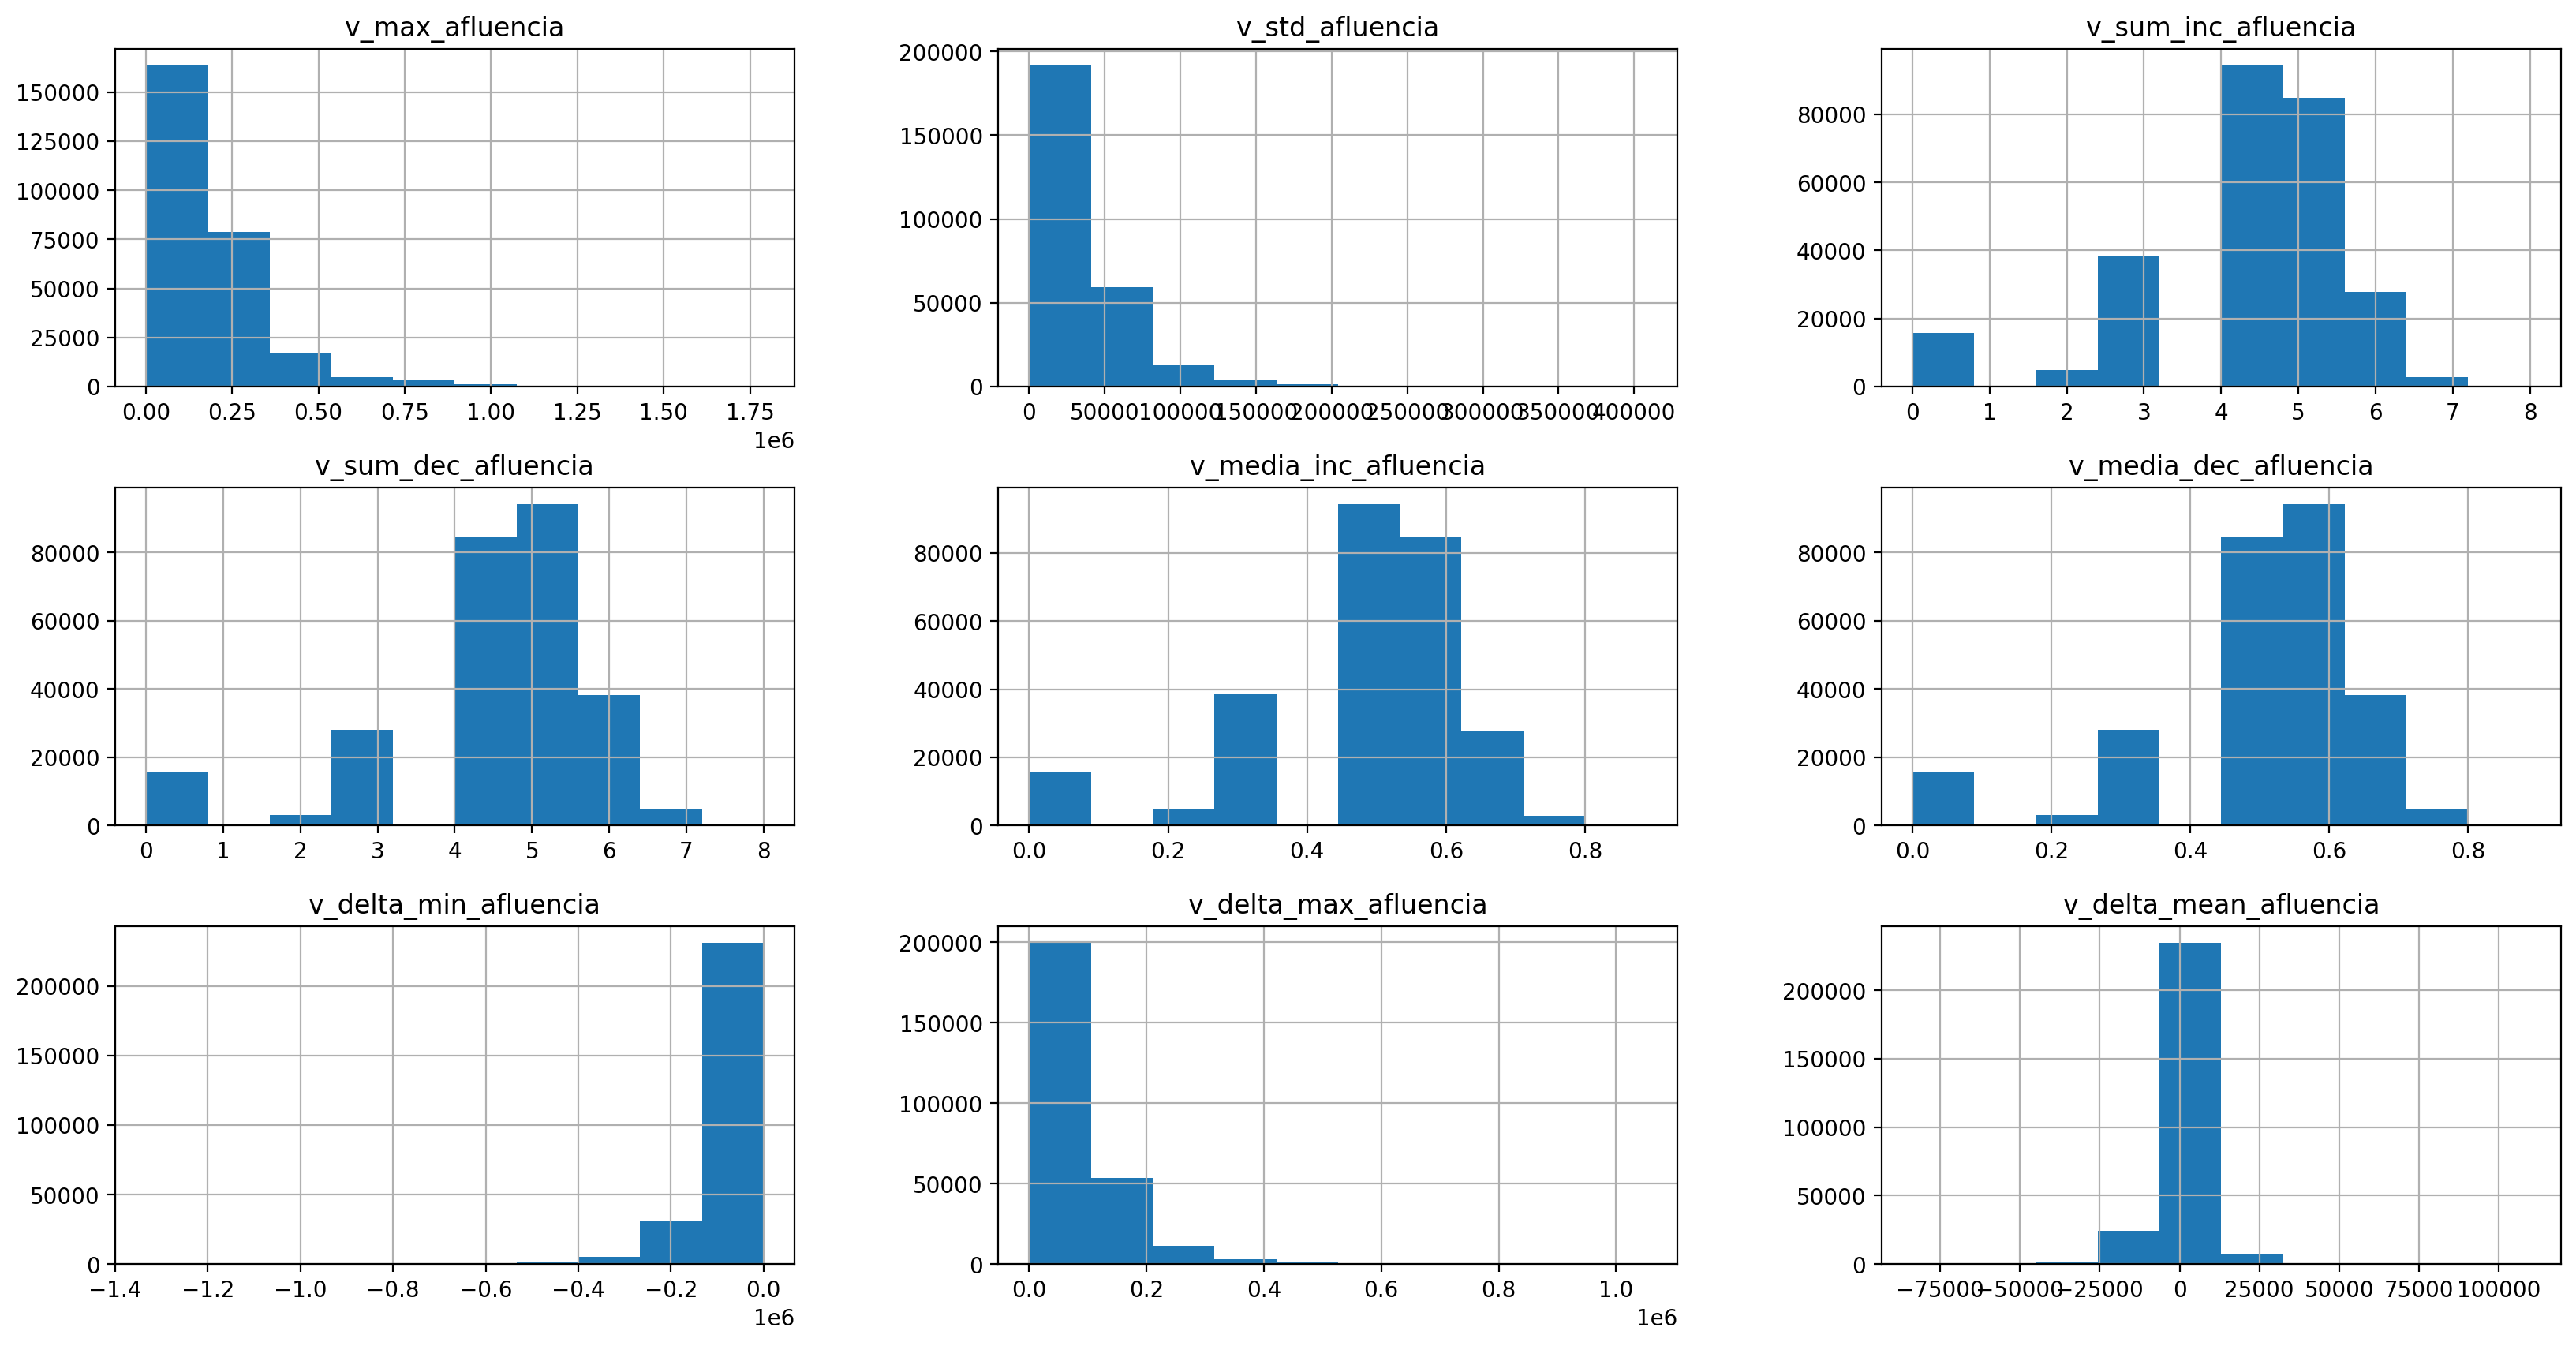

In [28]:
X[cols_cont[3:12]].hist(figsize=(20, 10))

### Análisis Univariado

#### Valores Ausentes

In [29]:
miss = 1 - X[cols_cont].describe().T[['count']] / len(tad)
miss

,count
v_sum_afluencia,0.000000
v_min_afluencia,0.000000
v_mean_afluencia,0.000000
v_max_afluencia,0.000000
v_std_afluencia,0.000000
v_sum_inc_afluencia,0.000000
v_sum_dec_afluencia,0.000000
v_media_inc_afluencia,0.000000
v_media_dec_afluencia,0.000000
v_delta_min_afluencia,0.000000


In [30]:
X.shape , X.dropna().shape , X.dropna().shape[0] / X.shape[0]

((269100, 21), (269100, 21), 1.0)

#### Imputación

In [31]:
# Esto puede ser tan complejo o sofisticado como negocio o la variable lo requiera
im = SimpleImputer(strategy='median')

In [32]:
im.fit(X)

SimpleImputer(strategy='median')

In [33]:
X[cols_cont]

,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_media_inc_afluencia,v_media_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_min_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,v_max_racha_inc_afluencia,v_max_racha_dec_afluencia,v_media_racha_inc_afluencia,v_media_racha_dec_afluencia
0,1538718,39059,"153,871.800000",257761,"91,233.811354",5,4,0.555556,0.444444,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",-0.827786,3.083777,0.545427,1.235866,2,2,1.000000,0.666667
1,2358299,48321,"235,829.900000",368193,"106,206.846405",3,6,0.333333,0.666667,"-319,872.000000","253,813.000000",-173.111111,"187,447.334079",-0.868762,5.074171,0.709150,1.807480,1,3,0.428571,1.500000
2,375640,17515,"37,564.000000",54652,"12,687.905685",3,6,0.333333,0.666667,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",-0.522402,1.464516,0.152796,0.641499,1,3,0.428571,1.500000
3,1760254,40677,"176,025.400000",253680,"71,681.461608",7,2,0.777778,0.222222,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",-0.831095,4.357573,0.549353,1.442348,3,1,2.333333,0.250000
4,1938085,82758,"193,808.500000",255863,"53,239.580955",4,5,0.444444,0.555556,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",-0.532240,0.970951,0.074904,0.407847,2,3,0.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269095,4050,405,405.000000,405,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000
269096,612947,38902,"61,294.700000",71912,"11,646.379953",5,4,0.555556,0.444444,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",-0.443016,0.652917,0.068500,0.370158,3,2,1.000000,0.666667
269097,2885651,269899,"288,565.100000",336441,"20,369.570614",5,4,0.555556,0.444444,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",-0.117212,0.235244,0.015126,0.090890,3,3,1.000000,0.666667
269098,2310010,140453,"231,001.000000",280277,"47,489.221879",6,3,0.666667,0.333333,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",-0.413660,0.842809,0.116281,0.350651,3,1,1.500000,0.428571


In [34]:
X[cols_cont] = im.transform( X[cols_cont] )

In [35]:
X[cols_cont]

,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_media_inc_afluencia,v_media_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_min_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,v_max_racha_inc_afluencia,v_max_racha_dec_afluencia,v_media_racha_inc_afluencia,v_media_racha_dec_afluencia
0,"1,538,718.000000","39,059.000000","153,871.800000","257,761.000000","91,233.811354",5.000000,4.000000,0.555556,0.444444,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",-0.827786,3.083777,0.545427,1.235866,2.000000,2.000000,1.000000,0.666667
1,"2,358,299.000000","48,321.000000","235,829.900000","368,193.000000","106,206.846405",3.000000,6.000000,0.333333,0.666667,"-319,872.000000","253,813.000000",-173.111111,"187,447.334079",-0.868762,5.074171,0.709150,1.807480,1.000000,3.000000,0.428571,1.500000
2,"375,640.000000","17,515.000000","37,564.000000","54,652.000000","12,687.905685",3.000000,6.000000,0.333333,0.666667,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",-0.522402,1.464516,0.152796,0.641499,1.000000,3.000000,0.428571,1.500000
3,"1,760,254.000000","40,677.000000","176,025.400000","253,680.000000","71,681.461608",7.000000,2.000000,0.777778,0.222222,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",-0.831095,4.357573,0.549353,1.442348,3.000000,1.000000,2.333333,0.250000
4,"1,938,085.000000","82,758.000000","193,808.500000","255,863.000000","53,239.580955",4.000000,5.000000,0.444444,0.555556,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",-0.532240,0.970951,0.074904,0.407847,2.000000,3.000000,0.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269095,"4,050.000000",405.000000,405.000000,405.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
269096,"612,947.000000","38,902.000000","61,294.700000","71,912.000000","11,646.379953",5.000000,4.000000,0.555556,0.444444,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",-0.443016,0.652917,0.068500,0.370158,3.000000,2.000000,1.000000,0.666667
269097,"2,885,651.000000","269,899.000000","288,565.100000","336,441.000000","20,369.570614",5.000000,4.000000,0.555556,0.444444,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",-0.117212,0.235244,0.015126,0.090890,3.000000,3.000000,1.000000,0.666667
269098,"2,310,010.000000","140,453.000000","231,001.000000","280,277.000000","47,489.221879",6.000000,3.000000,0.666667,0.333333,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",-0.413660,0.842809,0.116281,0.350651,3.000000,1.000000,1.500000,0.428571


#### Distribucion Alterada

> __Valores mayores a .1  se consideran distribuciones alteradas ( variables "rotas" )__

In [36]:
ks = pd.DataFrame( map( lambda v: ( v, ks_2samp( tad[v].dropna(), X[v] ).statistic ), cols_cont ), columns=['var', 'ks'] )
ks

,var,ks
0,v_sum_afluencia,0.000000
1,v_min_afluencia,0.000000
2,v_mean_afluencia,0.000000
3,v_max_afluencia,0.000000
4,v_std_afluencia,0.000000
5,v_sum_inc_afluencia,0.000000
6,v_sum_dec_afluencia,0.000000
7,v_media_inc_afluencia,0.000000
8,v_media_dec_afluencia,0.000000
9,v_delta_min_afluencia,0.000000


#### Varianza

- `class sklearn.feature_selection.VarianceThreshold(threshold=0.0)`

Feature selector that removes all low-variance features.

`VarianceThreshold` is a simple baseline approach to featire selection. 
It removes all features whose variance does not meet some threshold. By default, it removes all zero-variance features,
i.e. featires that have the same value in all samples.

As an example, suppose that we have a dataset woth boolean features, and we want to remove all features that are either one or zero (on or off)
in more than 80% of the samples. Boolean features are Bernoulli random variables, and the variance of such variables is given by

$$ Var[X] = p(1-p) $$

so we can select using the threshold `.8 * (1-.8)`

In [37]:
var_threshold = VarianceThreshold( threshold=1 )

In [38]:
var_threshold.fit( X[cols_cont] )

VarianceThreshold(threshold=1)

In [39]:
without_variance = [ v for v, u in zip( cols_cont, var_threshold.get_support() ) if not(u) ]
without_variance

['v_media_inc_afluencia',
 'v_media_dec_afluencia',
 'v_pct_delta_min_afluencia',
 'v_max_racha_inc_afluencia',
 'v_max_racha_dec_afluencia',
 'v_media_racha_inc_afluencia',
 'v_media_racha_dec_afluencia']

array([[<Axes: title={'center': 'v_media_inc_afluencia'}>,
        <Axes: title={'center': 'v_media_dec_afluencia'}>,
        <Axes: title={'center': 'v_pct_delta_min_afluencia'}>],
       [<Axes: title={'center': 'v_max_racha_inc_afluencia'}>,
        <Axes: title={'center': 'v_max_racha_dec_afluencia'}>,
        <Axes: title={'center': 'v_media_racha_inc_afluencia'}>],
       [<Axes: title={'center': 'v_media_racha_dec_afluencia'}>,
        <Axes: >, <Axes: >]], dtype=object)

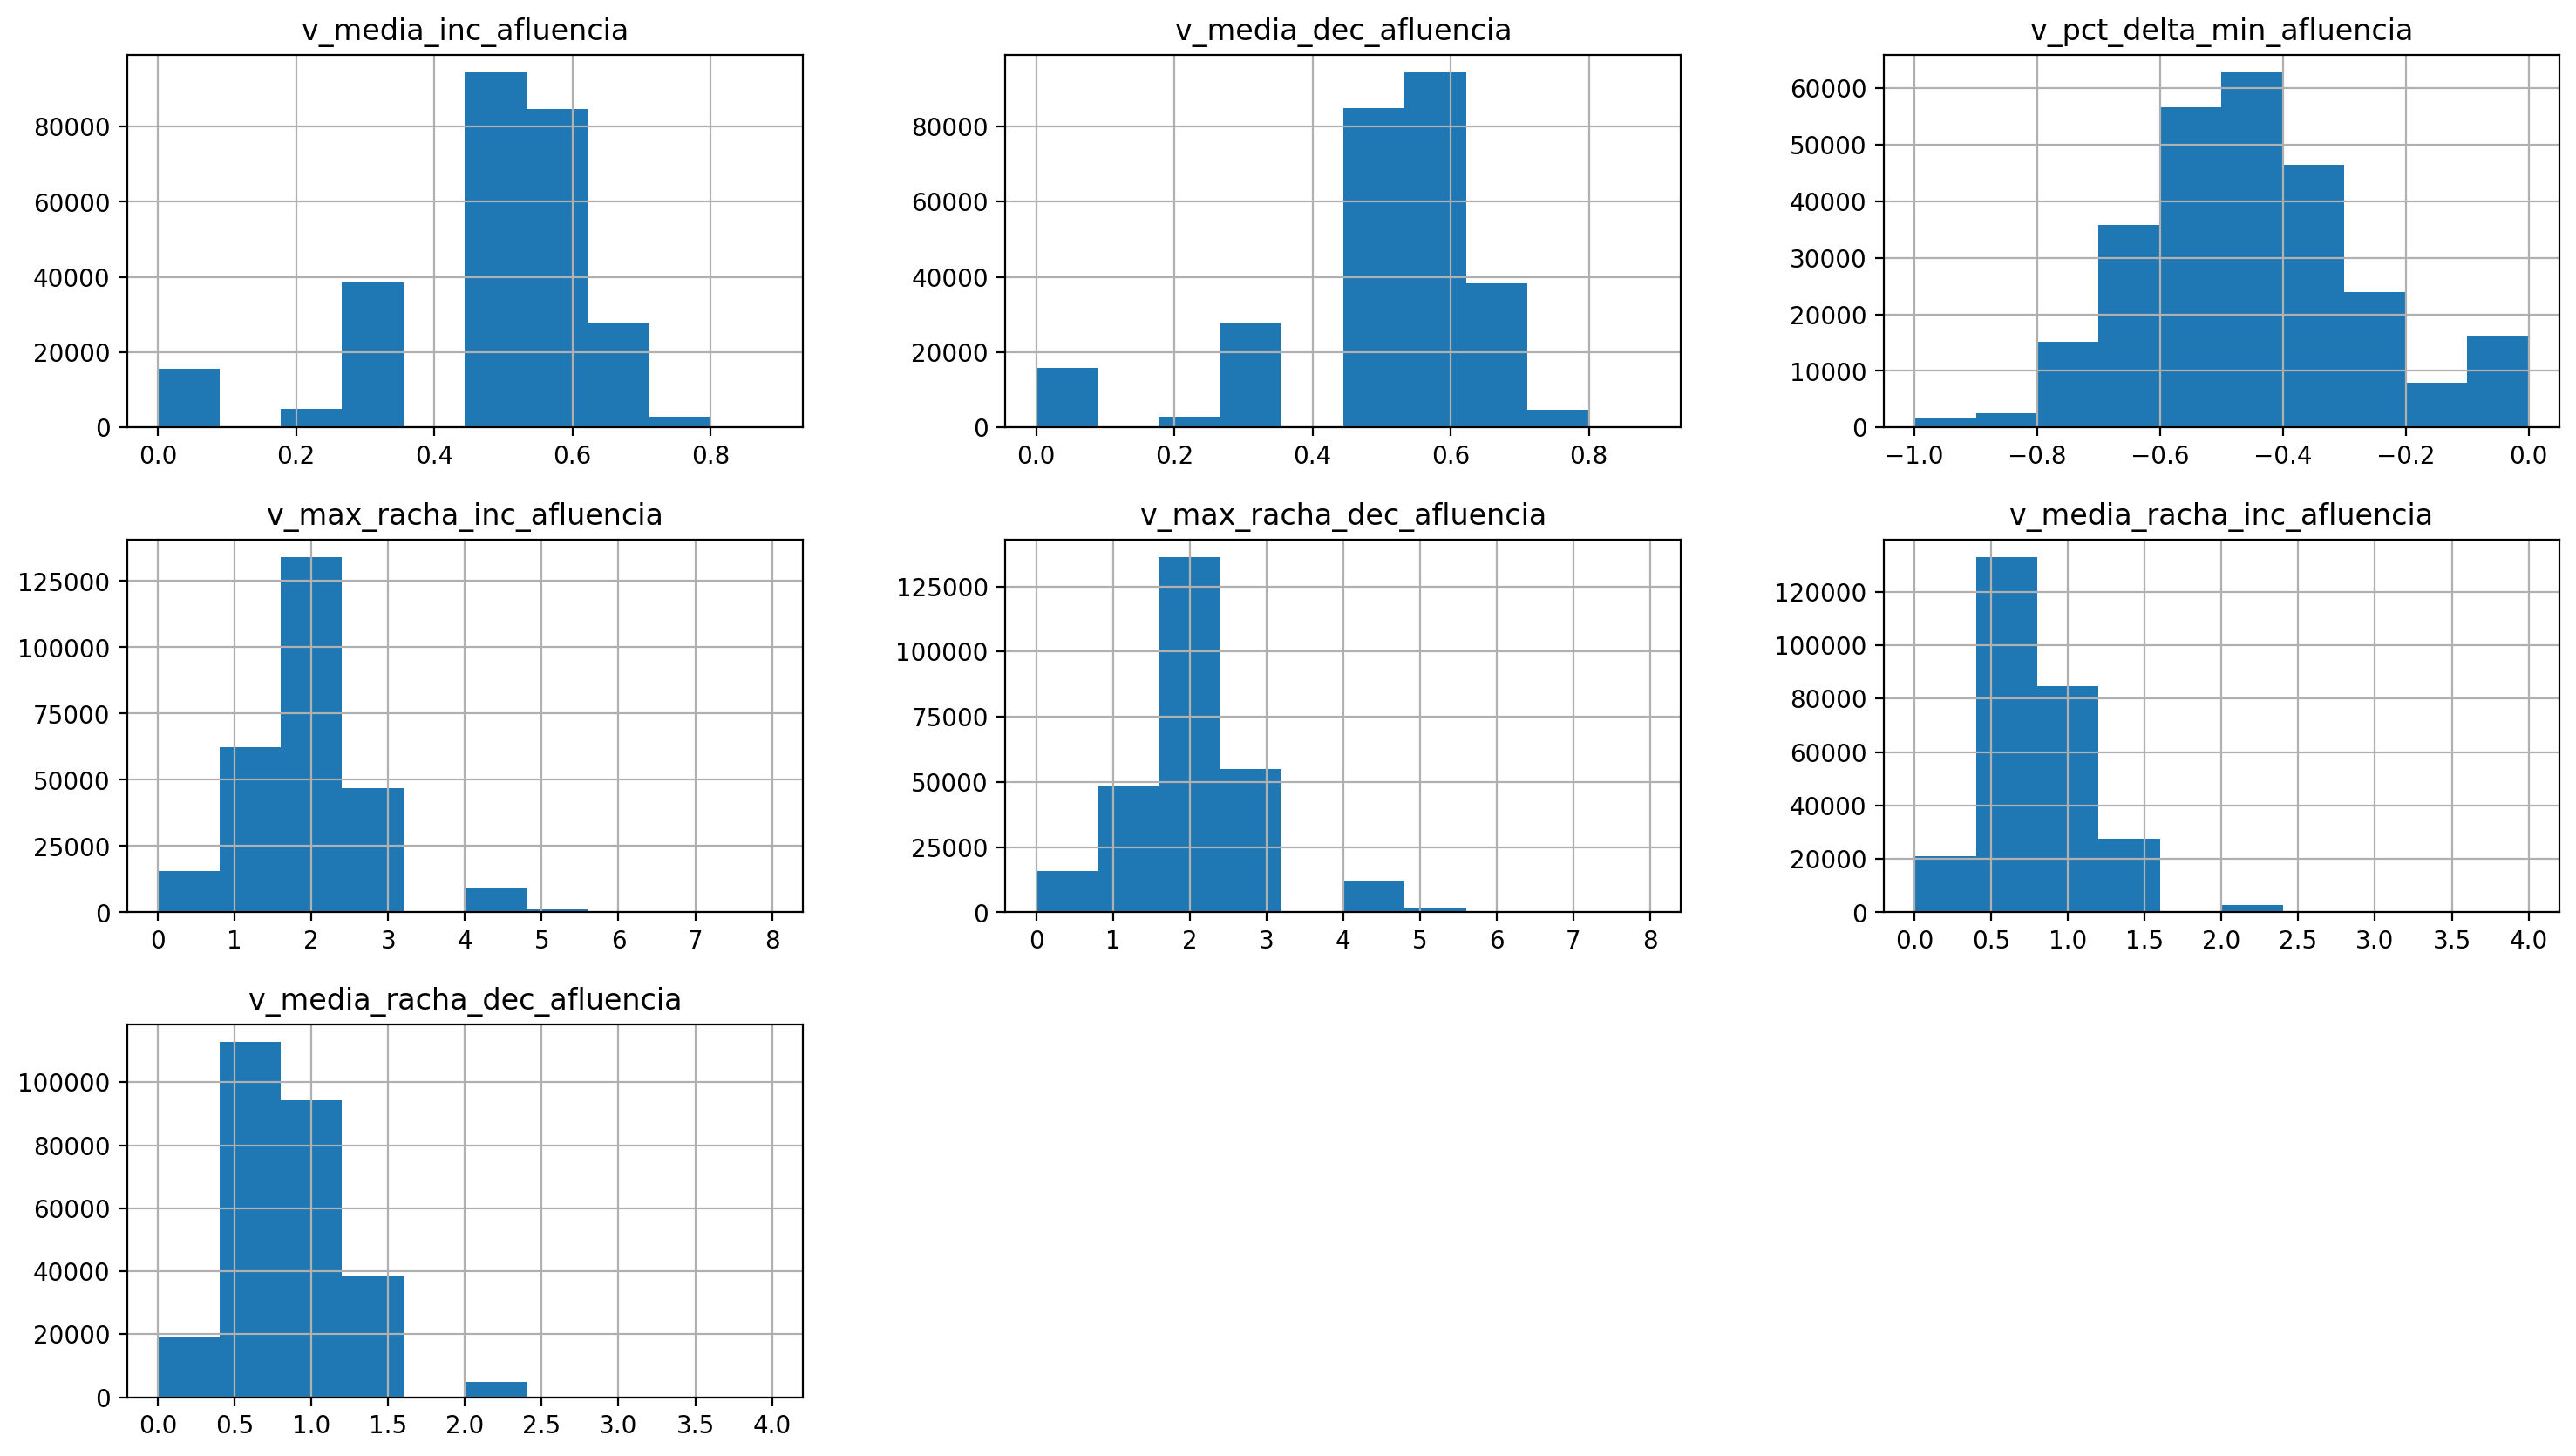

In [40]:
X[without_variance].hist(figsize=(18, 10))

In [41]:
cols_cont = [v for v in cols_cont if v not in without_variance]
cols_cont

['v_sum_afluencia',
 'v_min_afluencia',
 'v_mean_afluencia',
 'v_max_afluencia',
 'v_std_afluencia',
 'v_sum_inc_afluencia',
 'v_sum_dec_afluencia',
 'v_delta_min_afluencia',
 'v_delta_max_afluencia',
 'v_delta_mean_afluencia',
 'v_delta_desv_afluencia',
 'v_pct_delta_max_afluencia',
 'v_pct_delta_mean_afluencia',
 'v_pct_delta_desv_afluencia']

In [42]:
X.drop( without_variance, axis=1, inplace=True )
X

,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia
0,"1,538,718.000000","39,059.000000","153,871.800000","257,761.000000","91,233.811354",5.000000,4.000000,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",3.083777,0.545427,1.235866
1,"2,358,299.000000","48,321.000000","235,829.900000","368,193.000000","106,206.846405",3.000000,6.000000,"-319,872.000000","253,813.000000",-173.111111,"187,447.334079",5.074171,0.709150,1.807480
2,"375,640.000000","17,515.000000","37,564.000000","54,652.000000","12,687.905685",3.000000,6.000000,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",1.464516,0.152796,0.641499
3,"1,760,254.000000","40,677.000000","176,025.400000","253,680.000000","71,681.461608",7.000000,2.000000,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",4.357573,0.549353,1.442348
4,"1,938,085.000000","82,758.000000","193,808.500000","255,863.000000","53,239.580955",4.000000,5.000000,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",0.970951,0.074904,0.407847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269095,"4,050.000000",405.000000,405.000000,405.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
269096,"612,947.000000","38,902.000000","61,294.700000","71,912.000000","11,646.379953",5.000000,4.000000,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",0.652917,0.068500,0.370158
269097,"2,885,651.000000","269,899.000000","288,565.100000","336,441.000000","20,369.570614",5.000000,4.000000,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",0.235244,0.015126,0.090890
269098,"2,310,010.000000","140,453.000000","231,001.000000","280,277.000000","47,489.221879",6.000000,3.000000,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",0.842809,0.116281,0.350651


#### Extremos

In [43]:
X[cols_cont].describe(percentiles=[0.01,0.99]).T

,count,mean,std,min,1%,50%,99%,max
v_sum_afluencia,"269,100.000000","1,353,976.052036","1,258,339.414943","4,050.000000","4,050.000000","1,058,983.000000","6,635,594.550000","10,358,871.000000"
v_min_afluencia,"269,100.000000","74,334.556949","78,056.226627",405.000000,405.000000,"52,517.000000","405,390.730000","908,106.000000"
v_mean_afluencia,"269,100.000000","135,397.605204","125,833.941494",405.000000,405.000000,"105,898.300000","663,559.455000","1,035,887.100000"
v_max_afluencia,"269,100.000000","176,314.870145","160,028.629071",405.000000,405.000000,"139,535.000000","829,772.000000","1,789,298.000000"
v_std_afluencia,"269,100.000000","32,691.936392","30,339.372834",0.000000,0.000000,"24,857.544785","147,855.564708","408,335.766895"
v_sum_inc_afluencia,"269,100.000000",4.136838,1.400780,0.000000,0.000000,4.000000,7.000000,8.000000
v_sum_dec_afluencia,"269,100.000000",4.328216,1.437172,0.000000,0.000000,5.000000,7.000000,8.000000
v_delta_min_afluencia,"269,100.000000","-73,529.444575","72,483.820830","-1,333,672.000000","-355,574.000000","-53,825.000000",0.000000,0.000000
v_delta_max_afluencia,"269,100.000000","78,576.164987","76,551.885142",0.000000,0.000000,"57,559.000000","375,118.000000","1,052,359.000000"
v_delta_mean_afluencia,"269,100.000000",27.410628,"6,880.685913","-83,680.000000","-21,405.444444",0.000000,"21,209.000000","109,747.555556"


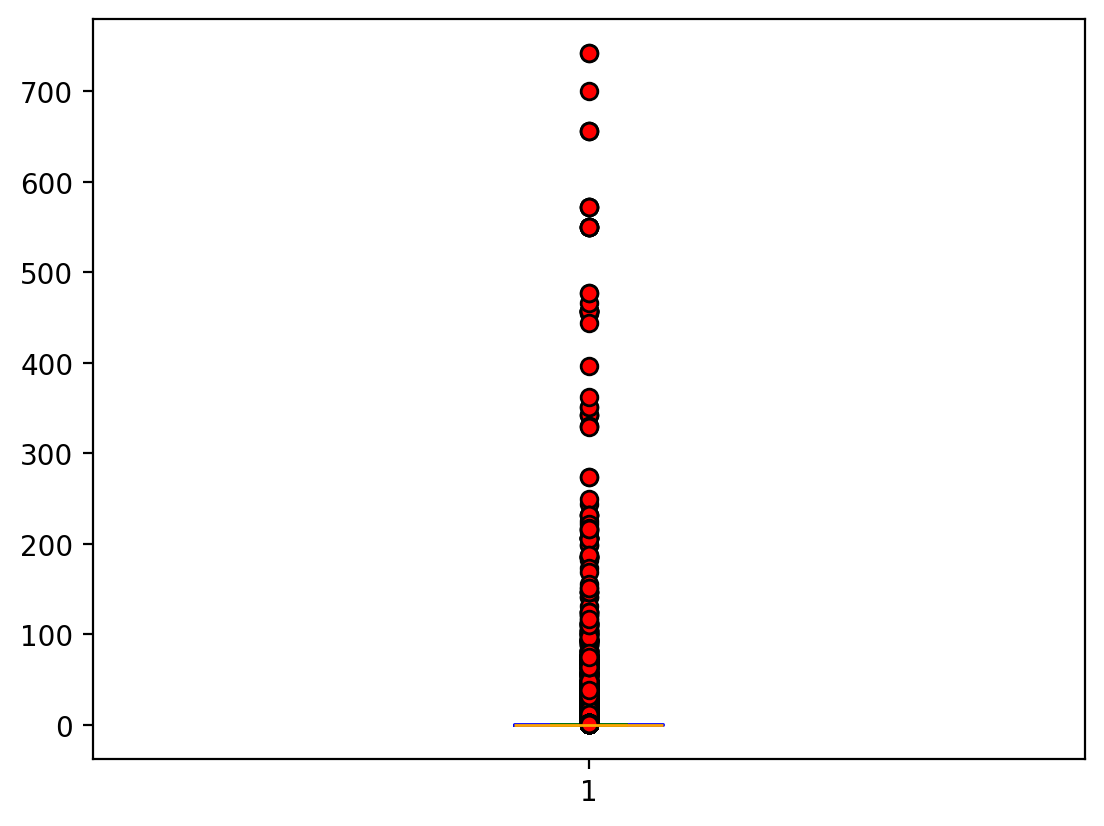

In [44]:
plt.boxplot(X['v_pct_delta_desv_afluencia'], 
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='red'), 
            capprops=dict(color='green'), 
            medianprops=dict(color='orange'), 
            flierprops=dict(markerfacecolor='red', marker='o'),
            vert=True)
plt.show()

In [45]:
outliers = X[cols_cont].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index()
outliers

,index,1%,99%
0,v_sum_afluencia,"4,050.000000","6,635,594.550000"
1,v_min_afluencia,405.000000,"405,390.730000"
2,v_mean_afluencia,405.000000,"663,559.455000"
3,v_max_afluencia,405.000000,"829,772.000000"
4,v_std_afluencia,0.000000,"147,855.564708"
5,v_sum_inc_afluencia,0.000000,7.000000
6,v_sum_dec_afluencia,0.000000,7.000000
7,v_delta_min_afluencia,"-355,574.000000",0.000000
8,v_delta_max_afluencia,0.000000,"375,118.000000"
9,v_delta_mean_afluencia,"-21,405.444444","21,209.000000"


In [46]:
pd.DataFrame(outliers.values)

,0,1,2
0,v_sum_afluencia,"4,050.000000","6,635,594.550000"
1,v_min_afluencia,405.000000,"405,390.730000"
2,v_mean_afluencia,405.000000,"663,559.455000"
3,v_max_afluencia,405.000000,"829,772.000000"
4,v_std_afluencia,0.000000,"147,855.564708"
5,v_sum_inc_afluencia,0.000000,7.000000
6,v_sum_dec_afluencia,0.000000,7.000000
7,v_delta_min_afluencia,"-355,574.000000",0.000000
8,v_delta_max_afluencia,0.000000,"375,118.000000"
9,v_delta_mean_afluencia,"-21,405.444444","21,209.000000"


In [47]:
for v, li, ls in outliers.values:
    X[f'ol_{v}'] = ( ( X[v] < li ) | (X[v] > ls) ).astype(int)

In [48]:
X.filter(like='ol_').columns.tolist()

['ol_v_sum_afluencia',
 'ol_v_min_afluencia',
 'ol_v_mean_afluencia',
 'ol_v_max_afluencia',
 'ol_v_std_afluencia',
 'ol_v_sum_inc_afluencia',
 'ol_v_sum_dec_afluencia',
 'ol_v_delta_min_afluencia',
 'ol_v_delta_max_afluencia',
 'ol_v_delta_mean_afluencia',
 'ol_v_delta_desv_afluencia',
 'ol_v_pct_delta_max_afluencia',
 'ol_v_pct_delta_mean_afluencia',
 'ol_v_pct_delta_desv_afluencia']

In [49]:
X['ext'] = X.filter(like='ol_').max(axis=1)
X.drop(X.filter(like='ol_').columns , axis=1 , inplace=True)
X['ext'].value_counts(True)

ext
0   0.944615
1   0.055385
Name: proportion, dtype: float64

In [50]:
X

,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,ext
0,"1,538,718.000000","39,059.000000","153,871.800000","257,761.000000","91,233.811354",5.000000,4.000000,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",3.083777,0.545427,1.235866,0
1,"2,358,299.000000","48,321.000000","235,829.900000","368,193.000000","106,206.846405",3.000000,6.000000,"-319,872.000000","253,813.000000",-173.111111,"187,447.334079",5.074171,0.709150,1.807480,1
2,"375,640.000000","17,515.000000","37,564.000000","54,652.000000","12,687.905685",3.000000,6.000000,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",1.464516,0.152796,0.641499,0
3,"1,760,254.000000","40,677.000000","176,025.400000","253,680.000000","71,681.461608",7.000000,2.000000,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",4.357573,0.549353,1.442348,0
4,"1,938,085.000000","82,758.000000","193,808.500000","255,863.000000","53,239.580955",4.000000,5.000000,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",0.970951,0.074904,0.407847,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269095,"4,050.000000",405.000000,405.000000,405.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
269096,"612,947.000000","38,902.000000","61,294.700000","71,912.000000","11,646.379953",5.000000,4.000000,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",0.652917,0.068500,0.370158,0
269097,"2,885,651.000000","269,899.000000","288,565.100000","336,441.000000","20,369.570614",5.000000,4.000000,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",0.235244,0.015126,0.090890,0
269098,"2,310,010.000000","140,453.000000","231,001.000000","280,277.000000","47,489.221879",6.000000,3.000000,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",0.842809,0.116281,0.350651,0


In [51]:
X.shape, tad.shape

((269100, 15), (269100, 25))

__Antes de eliminar "renglones" asegurar que se tiene la unidad muestral, el id, y el identificador, ..., stc.__

In [52]:
X[ um + ['ancla']] = tad[ um + ['ancla'] ]

In [53]:
X = X.loc[ X['ext'] == 0 ].reset_index(drop=True).drop(['ext'], axis=1)

In [54]:
X.shape, tad.shape

((254196, 16), (269100, 25))

#### Multivariado

In [55]:
X[cols_cont].corr()

,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia
v_sum_afluencia,1.000000,0.936017,1.000000,0.987902,0.862413,0.224842,0.266802,-0.826711,0.843477,0.006354,0.849453,0.076027,0.027979,0.086141
v_min_afluencia,0.936017,1.000000,0.936017,0.906045,0.665847,0.205705,0.226705,-0.640902,0.650678,0.001848,0.659148,-0.150396,-0.160345,-0.136629
v_mean_afluencia,1.000000,0.936017,1.000000,0.987902,0.862413,0.224842,0.266802,-0.826711,0.843477,0.006354,0.849453,0.076027,0.027979,0.086141
v_max_afluencia,0.987902,0.906045,0.987902,1.000000,0.908600,0.224169,0.276564,-0.862229,0.878443,0.005533,0.892714,0.129443,0.085964,0.147711
v_std_afluencia,0.862413,0.665847,0.862413,0.908600,1.000000,0.207690,0.273747,-0.930745,0.943380,0.007568,0.974320,0.376010,0.329492,0.408914
v_sum_inc_afluencia,0.224842,0.205705,0.224842,0.224169,0.207690,1.000000,0.145941,-0.238616,0.157524,0.210013,0.201817,0.196007,0.235919,0.244893
v_sum_dec_afluencia,0.266802,0.226705,0.266802,0.276564,0.273747,0.145941,1.000000,-0.216928,0.299184,-0.198017,0.267341,0.348293,0.128276,0.384386
v_delta_min_afluencia,-0.826711,-0.640902,-0.826711,-0.862229,-0.930745,-0.238616,-0.216928,1.000000,-0.881188,0.082734,-0.955993,-0.330405,-0.283563,-0.371595
v_delta_max_afluencia,0.843477,0.650678,0.843477,0.878443,0.943380,0.157524,0.299184,-0.881188,1.000000,0.074850,0.958775,0.441477,0.361129,0.443746
v_delta_mean_afluencia,0.006354,0.001848,0.006354,0.005533,0.007568,0.210013,-0.198017,0.082734,0.074850,1.000000,0.003852,0.089865,0.383770,0.069896


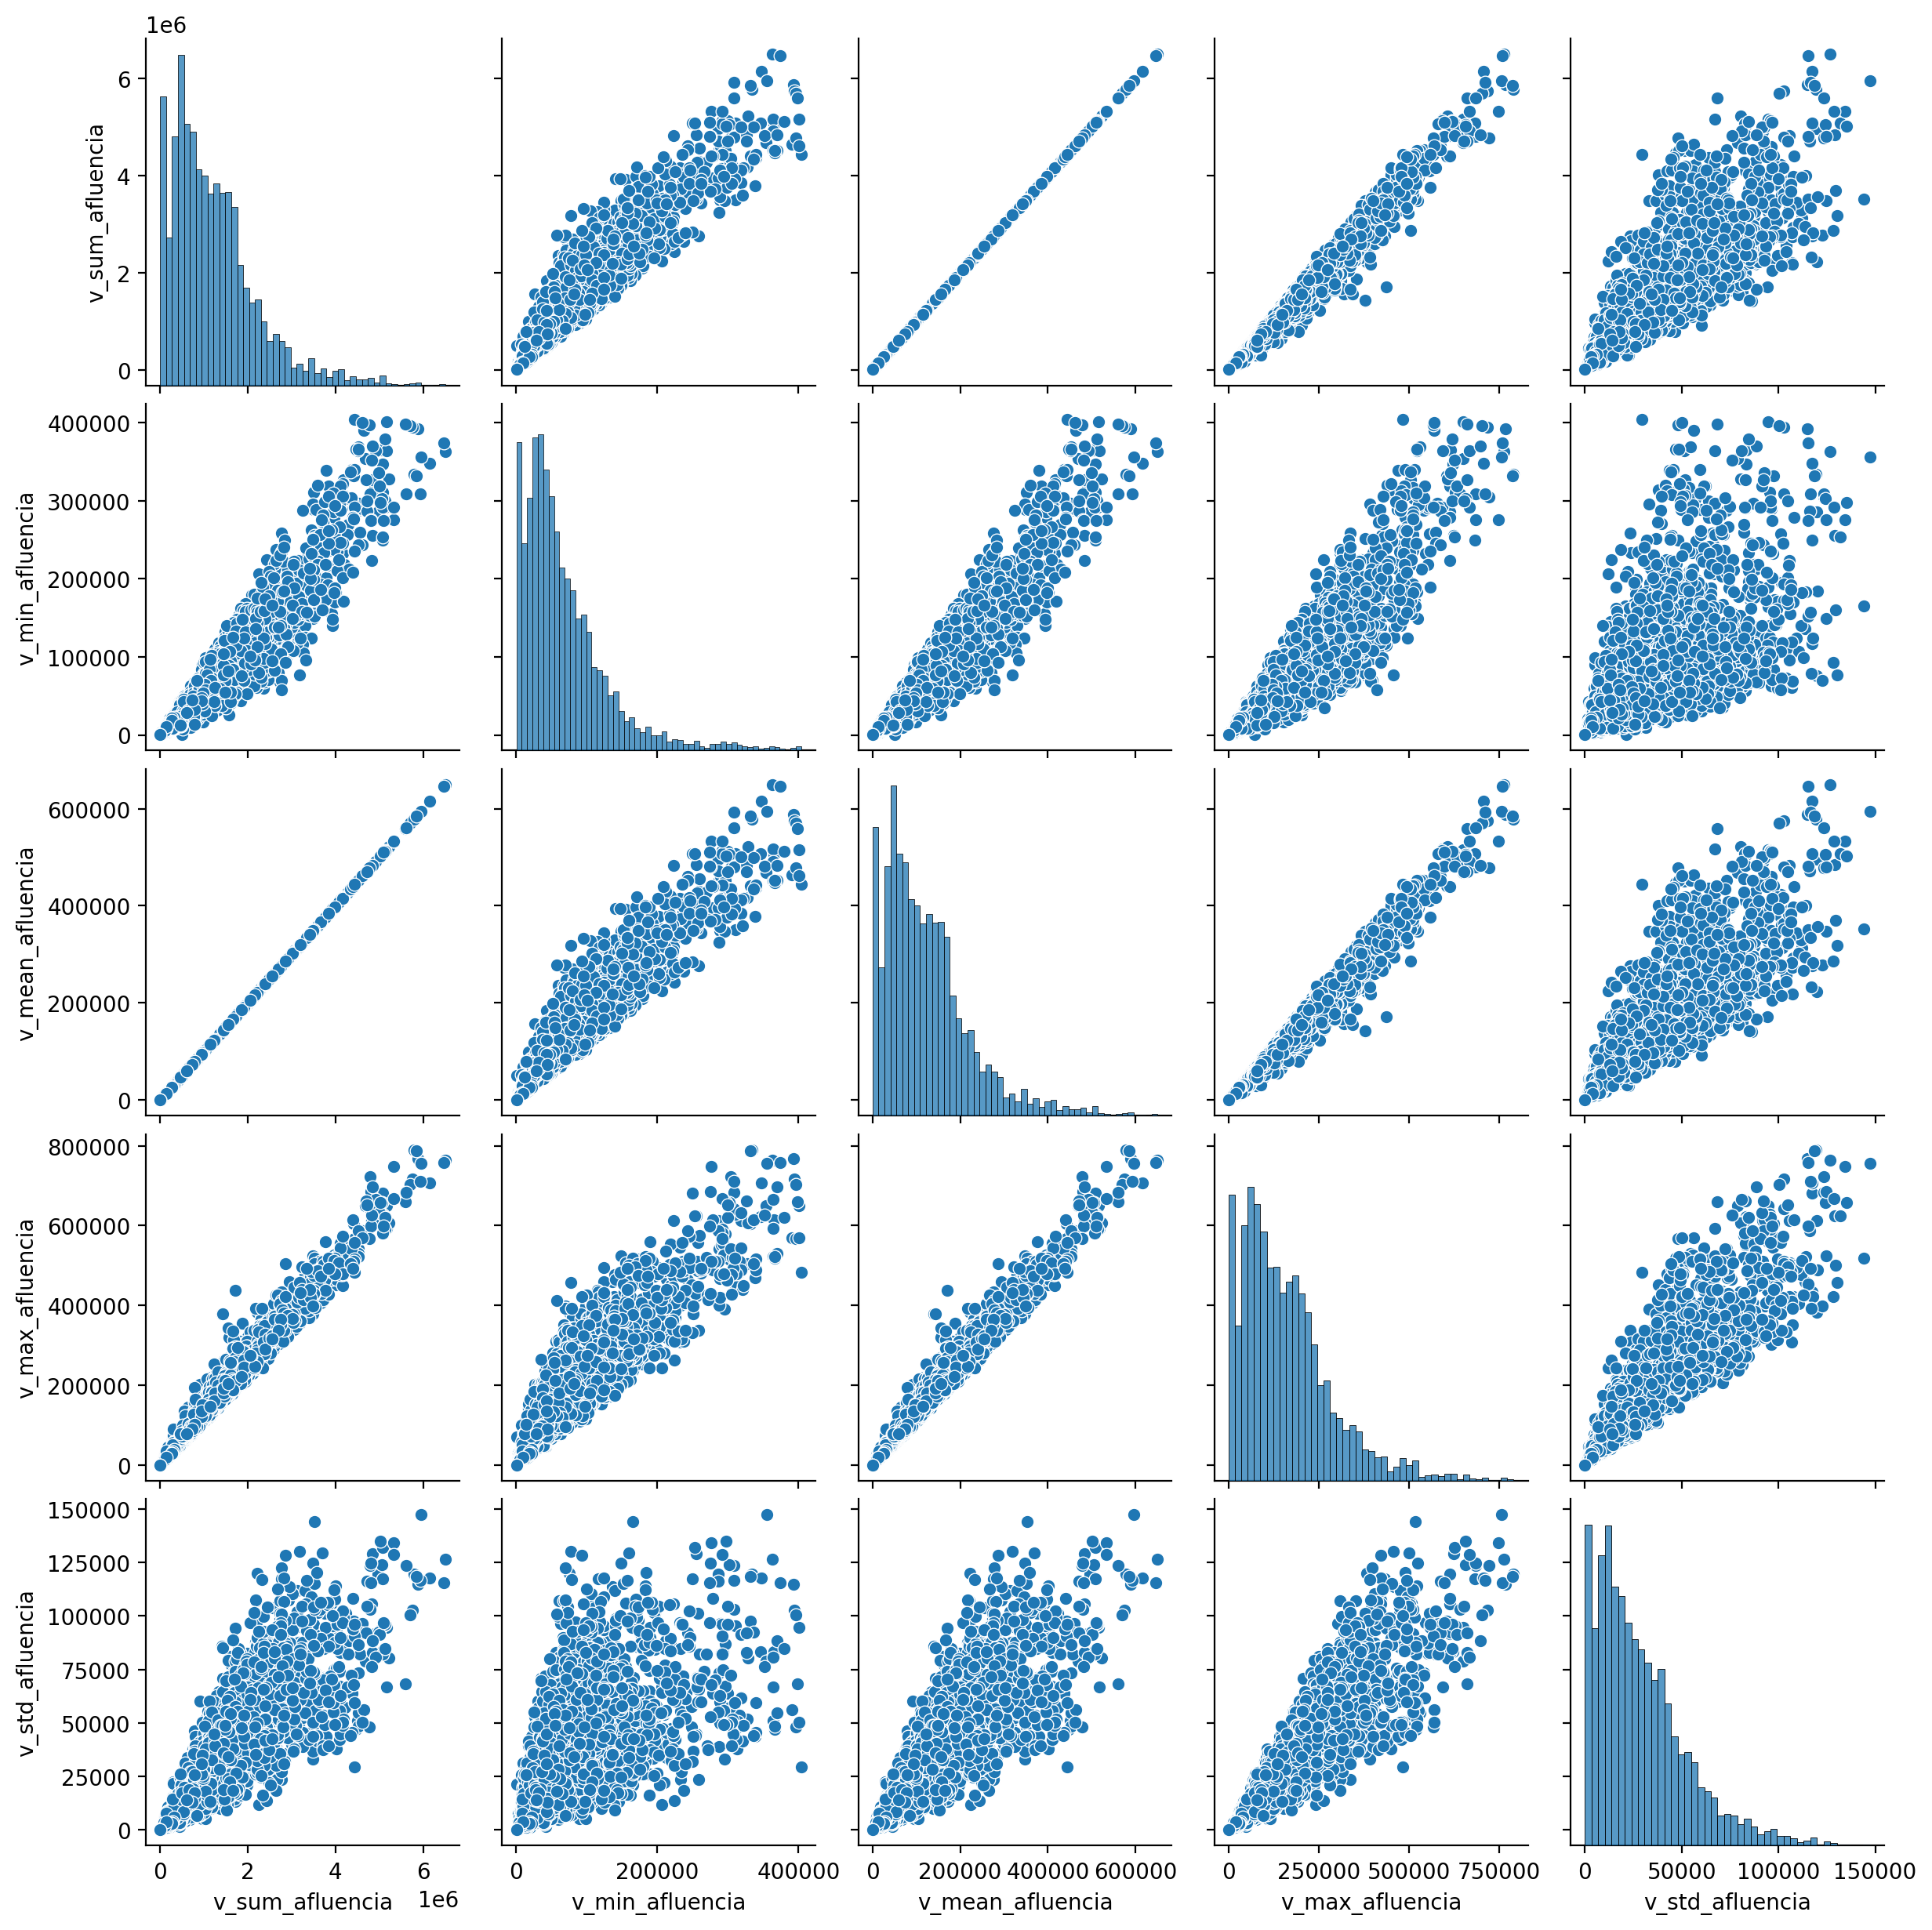

In [56]:
sns.pairplot(X[cols_cont[:5]].sample(5000))

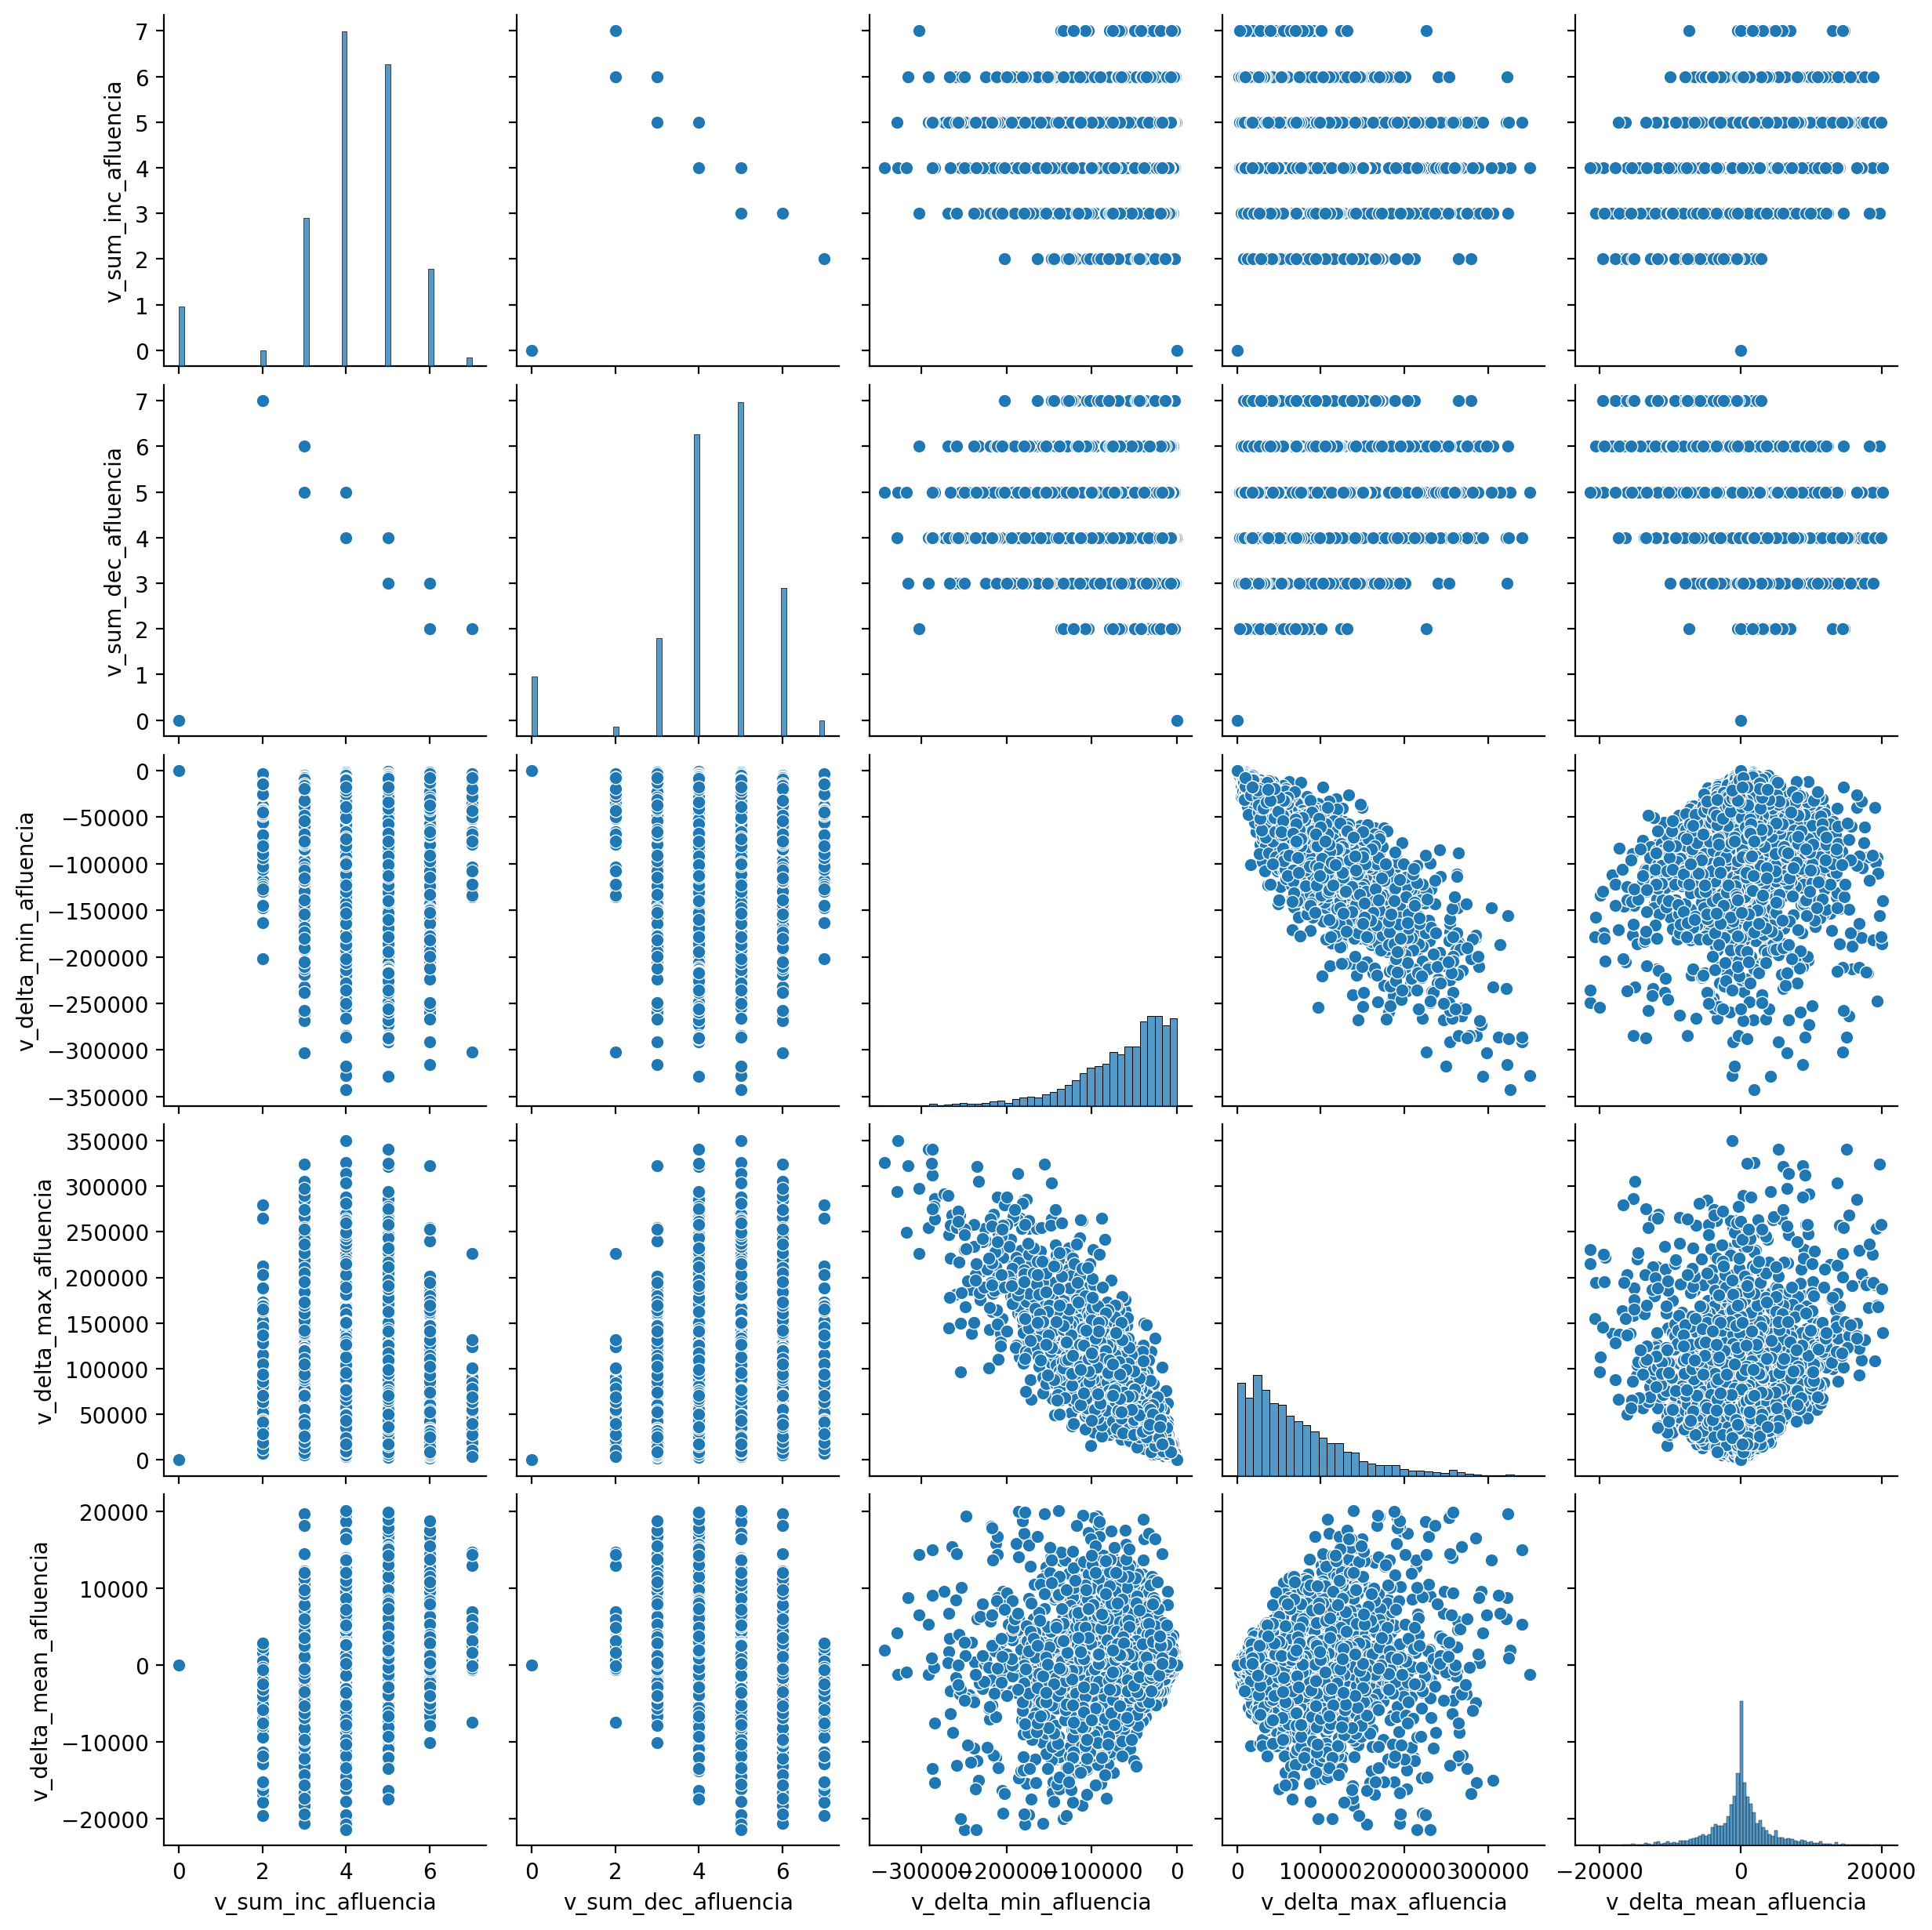

In [57]:
sns.pairplot(X[cols_cont[5:10]].sample(3500))

#### Multicolinealidad

In [58]:
vc = VarClusHi( df=X[cols_cont], feat_list=cols_cont )

In [59]:
# Aqui se entrena el cluster
vc.varclus()

In [60]:
rs = vc.rsquare.sort_values(by=['Cluster', 'RS_Ratio'], ascending=[1,1]).reset_index(drop=True)
rs['id'] = rs.groupby('Cluster').cumcount() + 1
rs

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio,id
0,0,v_max_afluencia,0.972240,0.030658,0.028638,1
1,0,v_sum_afluencia,0.940992,0.028310,0.060728,2
2,0,v_mean_afluencia,0.940992,0.028310,0.060728,3
3,0,v_std_afluencia,0.904189,0.156156,0.113541,4
4,0,v_delta_desv_afluencia,0.901795,0.177623,0.119416,5
5,0,v_delta_max_afluencia,0.866820,0.187573,0.163928,6
6,0,v_delta_min_afluencia,0.847848,0.126803,0.174248,7
7,0,v_min_afluencia,0.718356,0.021102,0.287716,8
8,1,v_pct_delta_desv_afluencia,0.963200,0.061338,0.039205,1
9,1,v_pct_delta_max_afluencia,0.933246,0.050705,0.070320,2


In [61]:
rs.loc[ rs['id'] == 1] # Las mejores variables

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio,id
0,0,v_max_afluencia,0.972240,0.030658,0.028638,1
8,1,v_pct_delta_desv_afluencia,0.963200,0.061338,0.039205,1
12,2,v_delta_mean_afluencia,0.599009,0.041204,0.418224,1


In [62]:
varc = rs.loc[ rs['id'] == 1]['Variable'].tolist()
varc

['v_max_afluencia', 'v_pct_delta_desv_afluencia', 'v_delta_mean_afluencia']

array([[<Axes: title={'center': 'v_max_afluencia'}>,
        <Axes: title={'center': 'v_pct_delta_desv_afluencia'}>],
       [<Axes: title={'center': 'v_delta_mean_afluencia'}>, <Axes: >]],
      dtype=object)

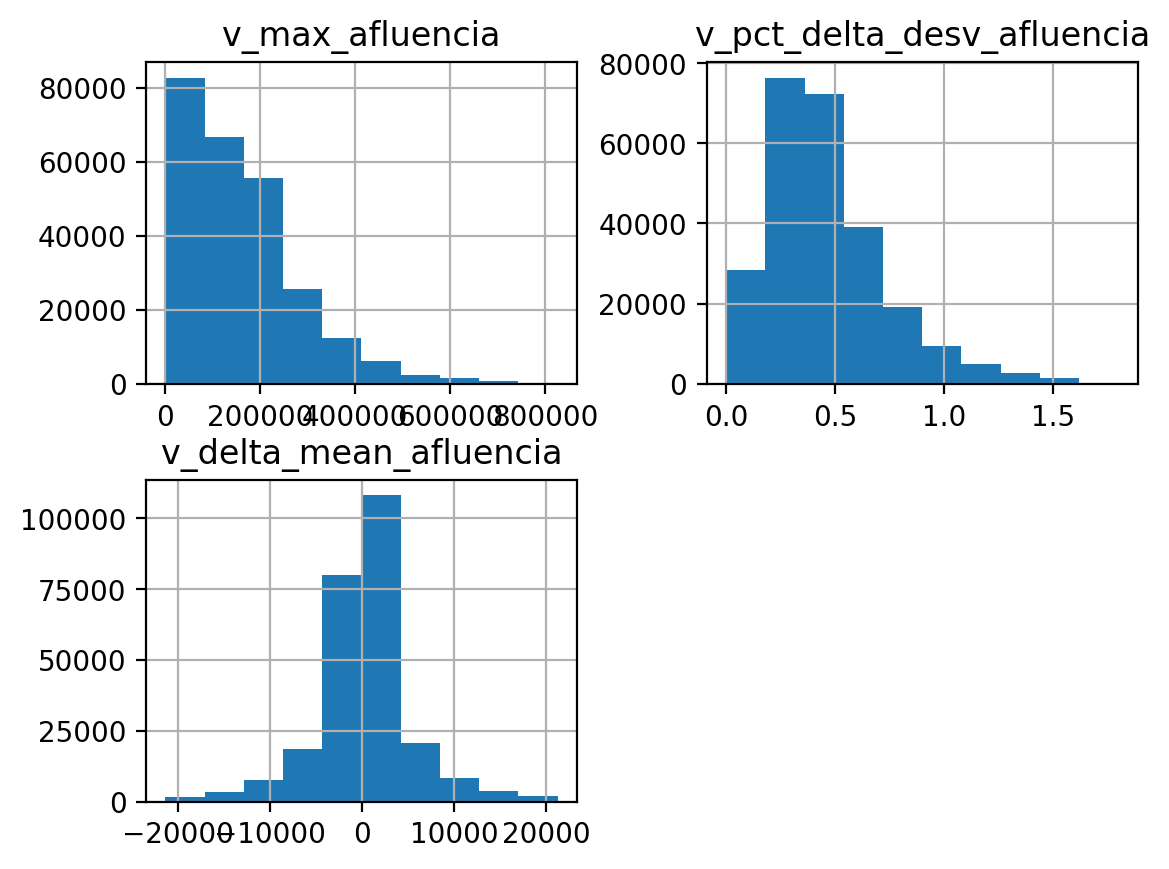

In [63]:
X[varc].hist()

## TAD Final - Modelo 1

In [64]:
X

,v_sum_afluencia,v_min_afluencia,v_mean_afluencia,v_max_afluencia,v_std_afluencia,v_sum_inc_afluencia,v_sum_dec_afluencia,v_delta_min_afluencia,v_delta_max_afluencia,v_delta_mean_afluencia,v_delta_desv_afluencia,v_pct_delta_max_afluencia,v_pct_delta_mean_afluencia,v_pct_delta_desv_afluencia,id_estacion,ancla
0,"1,538,718.000000","39,059.000000","153,871.800000","257,761.000000","91,233.811354",5.000000,4.000000,"-213,207.000000","162,897.000000","12,839.222222","107,050.551802",3.083777,0.545427,1.235866,Est00000,10
1,"375,640.000000","17,515.000000","37,564.000000","54,652.000000","12,687.905685",3.000000,6.000000,"-22,550.000000","25,651.000000",21.222222,"16,280.914128",1.464516,0.152796,0.641499,Est00002,10
2,"1,760,254.000000","40,677.000000","176,025.400000","253,680.000000","71,681.461608",7.000000,2.000000,"-200,150.000000","177,253.000000","7,721.444444","114,050.365986",4.357573,0.549353,1.442348,Est00003,10
3,"1,938,085.000000","82,758.000000","193,808.500000","255,863.000000","53,239.580955",4.000000,5.000000,"-94,166.000000","80,354.000000",307.555556,"53,689.554056",0.970951,0.074904,0.407847,Est00004,10
4,"149,559.000000","9,878.000000","14,955.900000","18,637.000000","3,121.649687",6.000000,3.000000,"-8,759.000000","5,556.000000",-276.555556,"4,375.044257",0.468584,0.020286,0.290186,Est00005,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254191,"4,050.000000",405.000000,405.000000,405.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Est00385,699
254192,"612,947.000000","38,902.000000","61,294.700000","71,912.000000","11,646.379953",5.000000,4.000000,"-30,942.000000","27,589.000000",198.777778,"19,684.627752",0.652917,0.068500,0.370158,Est00386,699
254193,"2,885,651.000000","269,899.000000","288,565.100000","336,441.000000","20,369.570614",5.000000,4.000000,"-39,435.000000","64,073.000000","3,205.222222","26,155.637598",0.235244,0.015126,0.090890,Est00387,699
254194,"2,310,010.000000","140,453.000000","231,001.000000","280,277.000000","47,489.221879",6.000000,3.000000,"-99,089.000000","118,375.000000","13,233.666667","61,485.217719",0.842809,0.116281,0.350651,Est00388,699


In [65]:
X[ um + ['ancla'] + varc ]

,id_estacion,ancla,v_max_afluencia,v_pct_delta_desv_afluencia,v_delta_mean_afluencia
0,Est00000,10,"257,761.000000",1.235866,"12,839.222222"
1,Est00002,10,"54,652.000000",0.641499,21.222222
2,Est00003,10,"253,680.000000",1.442348,"7,721.444444"
3,Est00004,10,"255,863.000000",0.407847,307.555556
4,Est00005,10,"18,637.000000",0.290186,-276.555556
...,...,...,...,...,...
254191,Est00385,699,405.000000,0.000000,0.000000
254192,Est00386,699,"71,912.000000",0.370158,198.777778
254193,Est00387,699,"336,441.000000",0.090890,"3,205.222222"
254194,Est00388,699,"280,277.000000",0.350651,"13,233.666667"


In [66]:
y

t,id_estacion,ancla,y
0,Est00000,10,"233,986.000000"
1,Est00001,10,"290,042.000000"
2,Est00002,10,"40,779.000000"
3,Est00003,10,"232,123.000000"
4,Est00004,10,"228,464.000000"
...,...,...,...
269095,Est00385,699,405.000000
269096,Est00386,699,"64,261.000000"
269097,Est00387,699,NaN
269098,Est00388,699,"266,479.000000"


In [68]:
TAD = X[ um + ['ancla'] + varc ].merge( y, on=['id_estacion', 'ancla'], how='inner' ).reset_index(drop=True)

In [69]:
TAD.head()

,id_estacion,ancla,v_max_afluencia,v_pct_delta_desv_afluencia,v_delta_mean_afluencia,y
0,Est00000,10,"257,761.000000",1.235866,"12,839.222222","233,986.000000"
1,Est00002,10,"54,652.000000",0.641499,21.222222,"40,779.000000"
2,Est00003,10,"253,680.000000",1.442348,"7,721.444444","232,123.000000"
3,Est00004,10,"255,863.000000",0.407847,307.555556,"228,464.000000"
4,Est00005,10,"18,637.000000",0.290186,-276.555556,"17,121.000000"


In [70]:
#y = tad[um+['ancla','y'] ]
y2 = tad[um+['ancla','y2'] ]

In [71]:
y2

,id_estacion,ancla,y2
0,Est00000,10,1
1,Est00001,10,1
2,Est00002,10,1
3,Est00003,10,1
4,Est00004,10,1
...,...,...,...
269095,Est00385,699,0
269096,Est00386,699,1
269097,Est00387,699,1
269098,Est00388,699,1


In [72]:
TAD_ = X[ um + ['ancla'] + varc ].merge( y2, on=['id_estacion', 'ancla'], how='inner' ).reset_index(drop=True)

In [73]:
TAD_.head()

,id_estacion,ancla,v_max_afluencia,v_pct_delta_desv_afluencia,v_delta_mean_afluencia,y2
0,Est00000,10,"257,761.000000",1.235866,"12,839.222222",1
1,Est00002,10,"54,652.000000",0.641499,21.222222,1
2,Est00003,10,"253,680.000000",1.442348,"7,721.444444",1
3,Est00004,10,"255,863.000000",0.407847,307.555556,1
4,Est00005,10,"18,637.000000",0.290186,-276.555556,1


<Axes: xlabel='y2'>

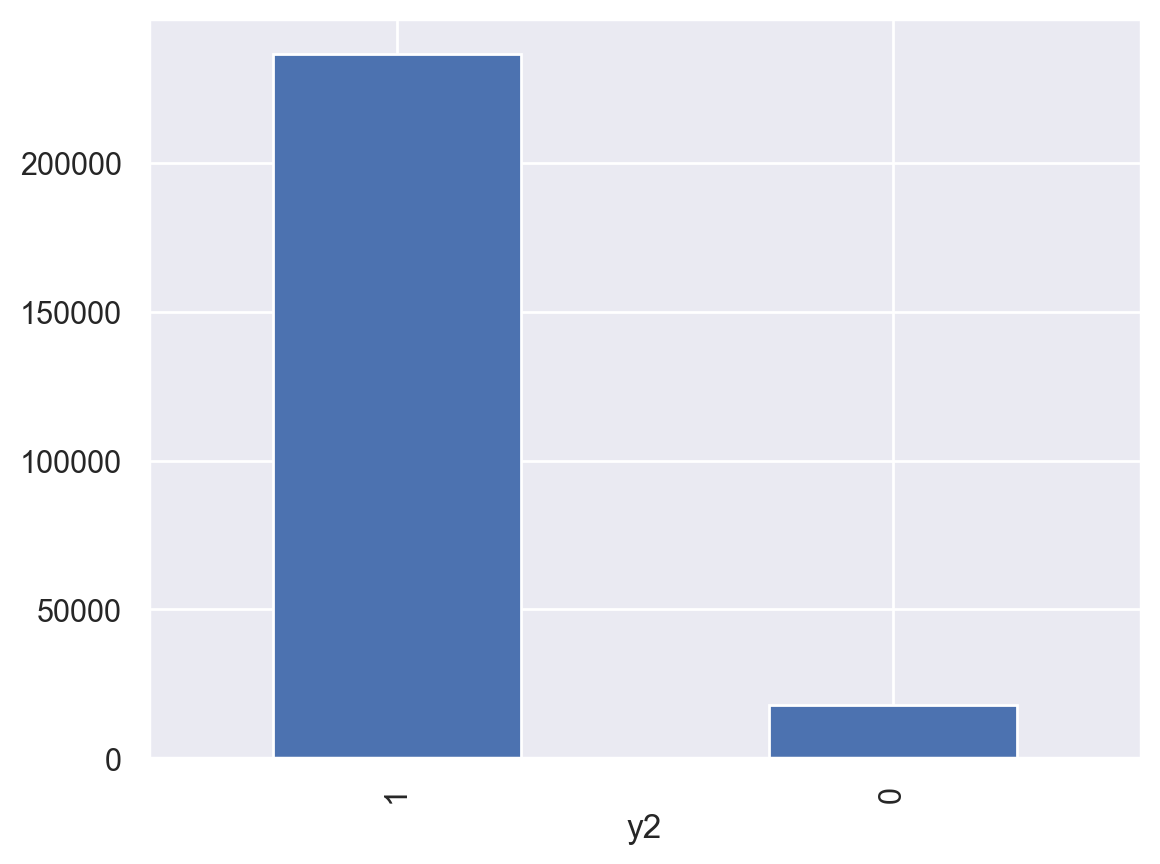

In [159]:
TAD_['y2'].value_counts().plot(kind='bar')

In [193]:
TAD.to_parquet("../data/output/TAD_01_ESTACIONES.parquet")
TAD_.to_parquet("../data/output/TAD_02_ESTACIONES.parquet")

## Modelo 1: Regresión

In [194]:
TAD = pd.read_parquet("../data/output/TAD_01_ESTACIONES.parquet")
TAD

,id_estacion,ancla,v_max_afluencia,v_pct_delta_desv_afluencia,v_delta_mean_afluencia,y
0,Est00000,10,"257,761.000000",1.235866,"12,839.222222","233,986.000000"
1,Est00002,10,"54,652.000000",0.641499,21.222222,"40,779.000000"
2,Est00003,10,"253,680.000000",1.442348,"7,721.444444","232,123.000000"
3,Est00004,10,"255,863.000000",0.407847,307.555556,"228,464.000000"
4,Est00005,10,"18,637.000000",0.290186,-276.555556,"17,121.000000"
...,...,...,...,...,...,...
253487,Est00384,699,"119,460.000000",0.682559,"2,011.333333","106,852.000000"
253488,Est00385,699,405.000000,0.000000,0.000000,405.000000
253489,Est00386,699,"71,912.000000",0.370158,198.777778,"64,261.000000"
253490,Est00388,699,"280,277.000000",0.350651,"13,233.666667","266,479.000000"


In [195]:
# Eliminamos los renglones/registros donde no se cuenta con la variable objetivo
TAD = TAD.loc[~TAD['y'].isna()].reset_index(drop=True)
TAD.head()

,id_estacion,ancla,v_max_afluencia,v_pct_delta_desv_afluencia,v_delta_mean_afluencia,y
0,Est00000,10,"257,761.000000",1.235866,"12,839.222222","233,986.000000"
1,Est00002,10,"54,652.000000",0.641499,21.222222,"40,779.000000"
2,Est00003,10,"253,680.000000",1.442348,"7,721.444444","232,123.000000"
3,Est00004,10,"255,863.000000",0.407847,307.555556,"228,464.000000"
4,Est00005,10,"18,637.000000",0.290186,-276.555556,"17,121.000000"


<Axes: >

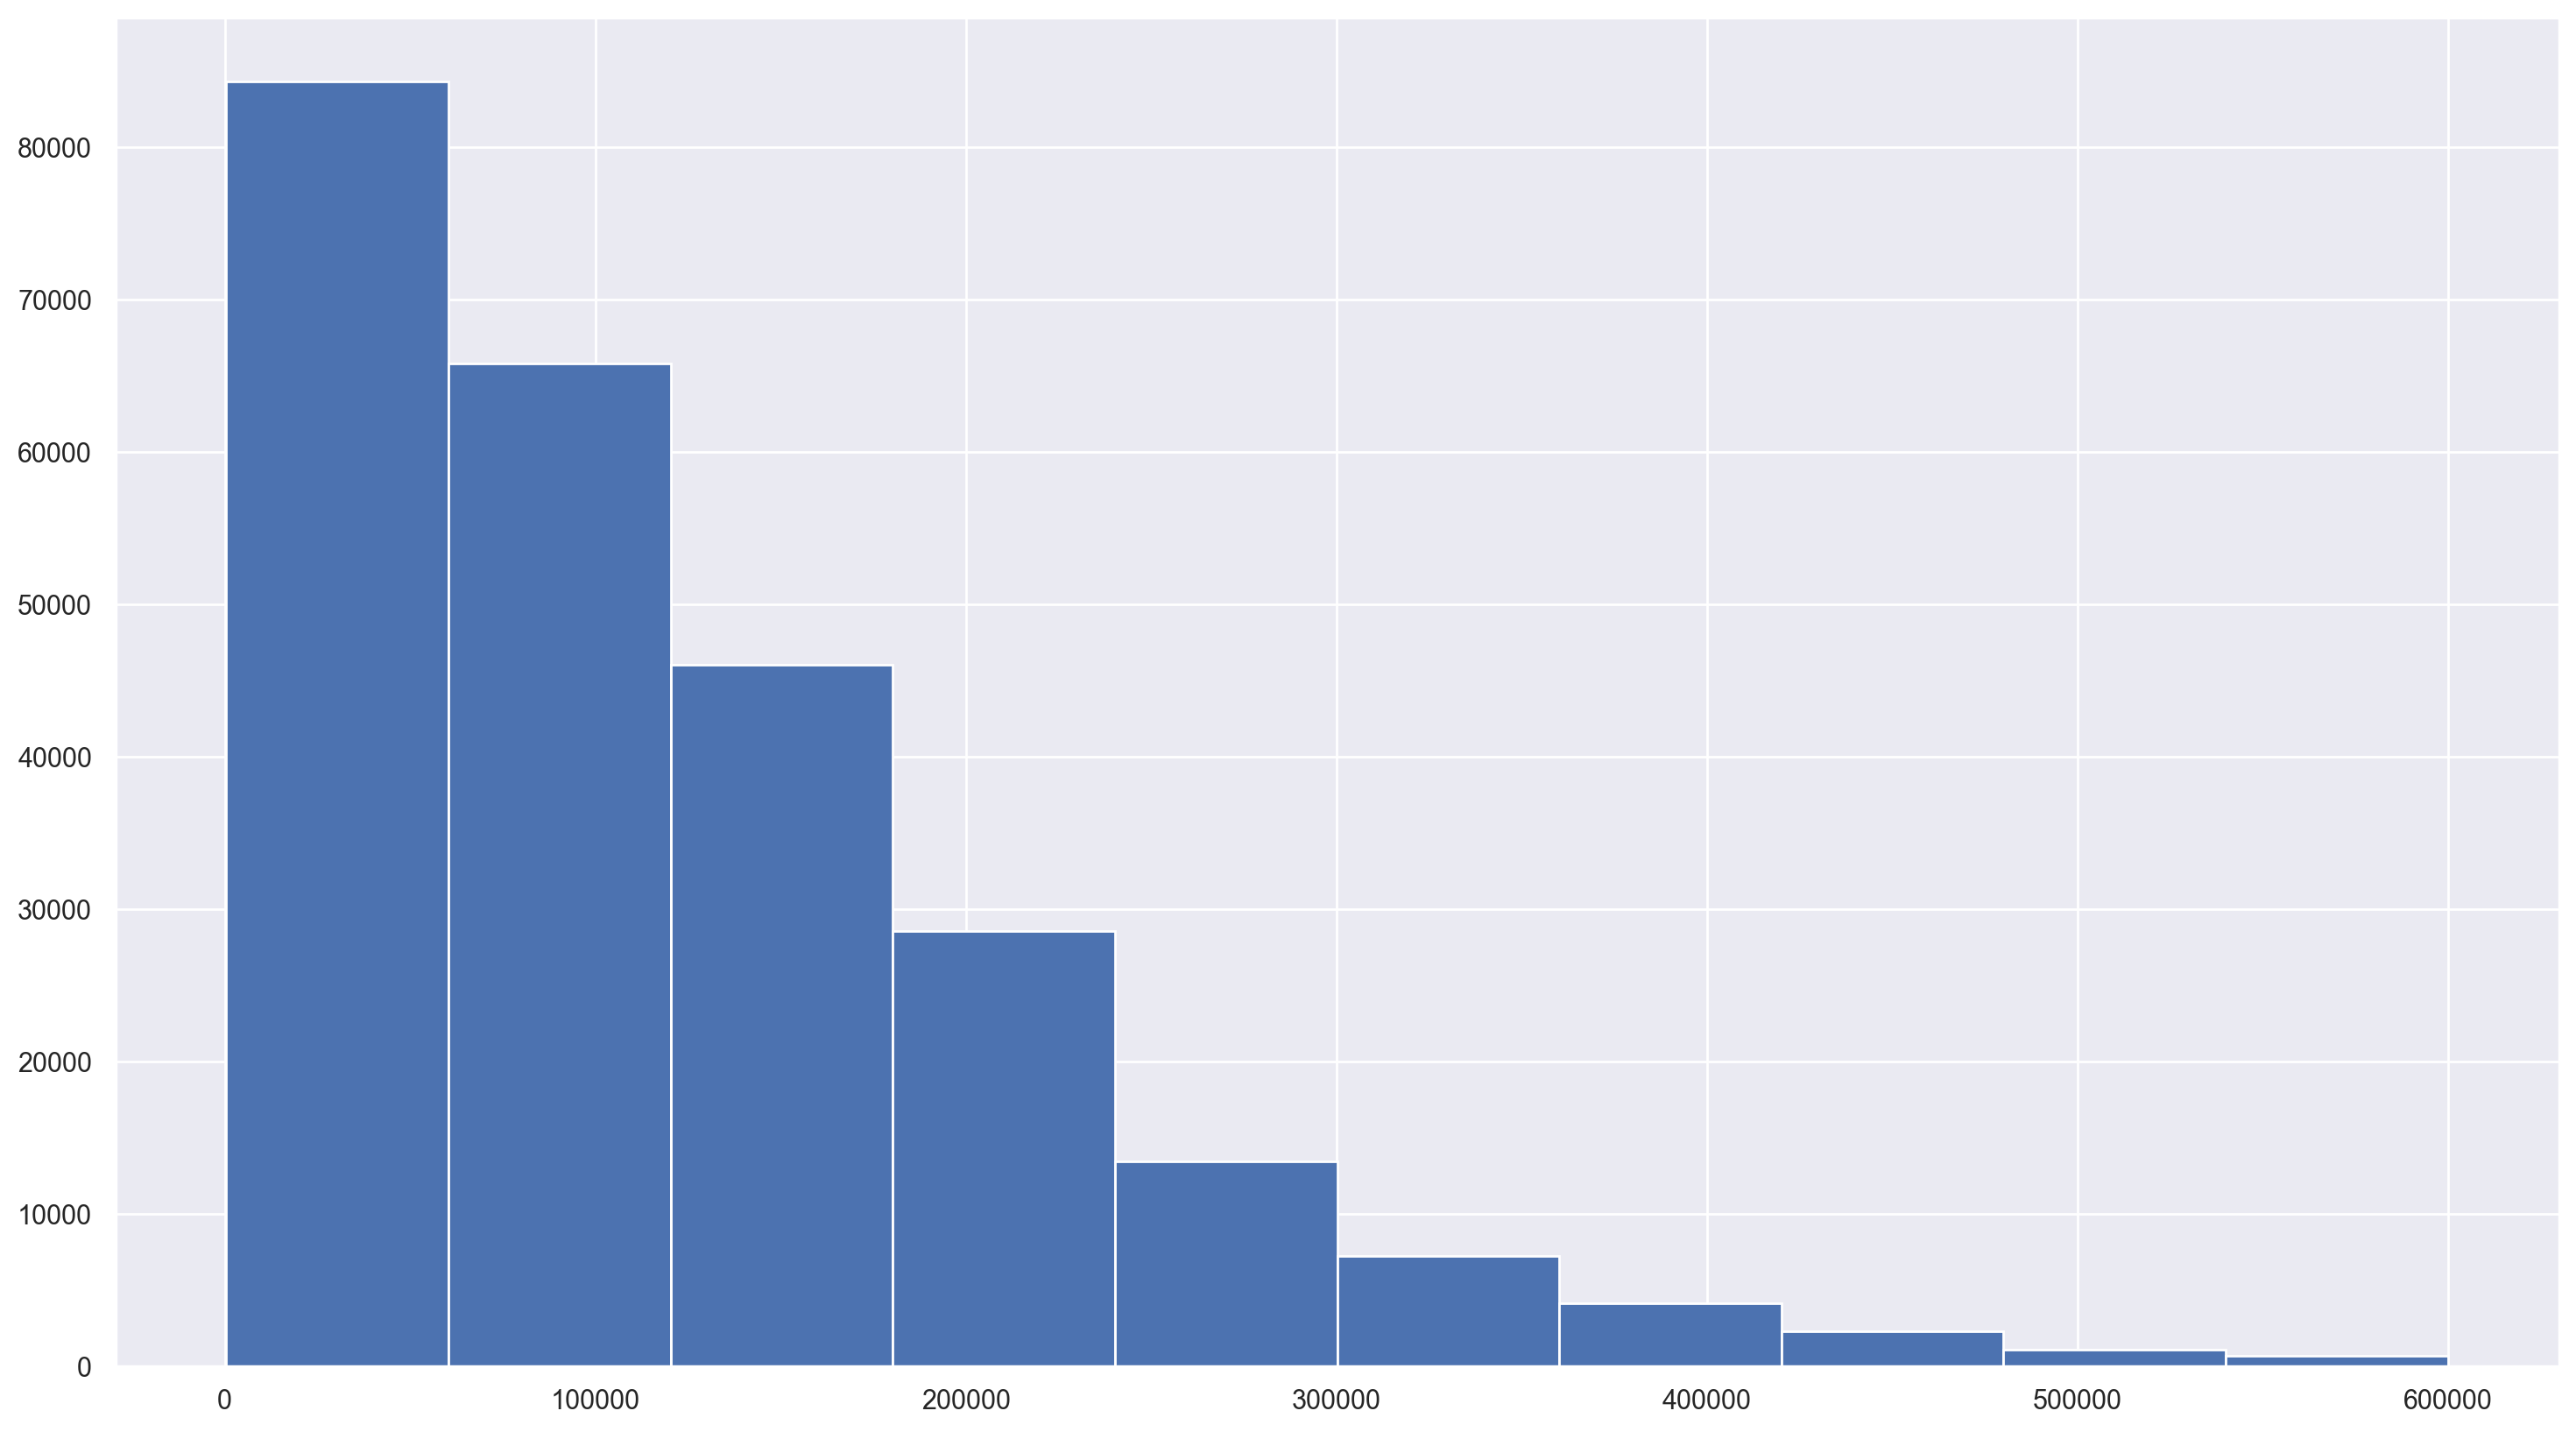

In [196]:
TAD['y'].hist(figsize=(18,10))

In [197]:
TAD.loc[ TAD['y'] < 600000].shape[0] / TAD.shape[0]

1.0

In [198]:
TAD = TAD.loc[ TAD['y'] < 600000].reset_index(drop=True)
TAD

,id_estacion,ancla,v_max_afluencia,v_pct_delta_desv_afluencia,v_delta_mean_afluencia,y
0,Est00000,10,"257,761.000000",1.235866,"12,839.222222","233,986.000000"
1,Est00002,10,"54,652.000000",0.641499,21.222222,"40,779.000000"
2,Est00003,10,"253,680.000000",1.442348,"7,721.444444","232,123.000000"
3,Est00004,10,"255,863.000000",0.407847,307.555556,"228,464.000000"
4,Est00005,10,"18,637.000000",0.290186,-276.555556,"17,121.000000"
...,...,...,...,...,...,...
253487,Est00384,699,"119,460.000000",0.682559,"2,011.333333","106,852.000000"
253488,Est00385,699,405.000000,0.000000,0.000000,405.000000
253489,Est00386,699,"71,912.000000",0.370158,198.777778,"64,261.000000"
253490,Est00388,699,"280,277.000000",0.350651,"13,233.666667","266,479.000000"


<Axes: >

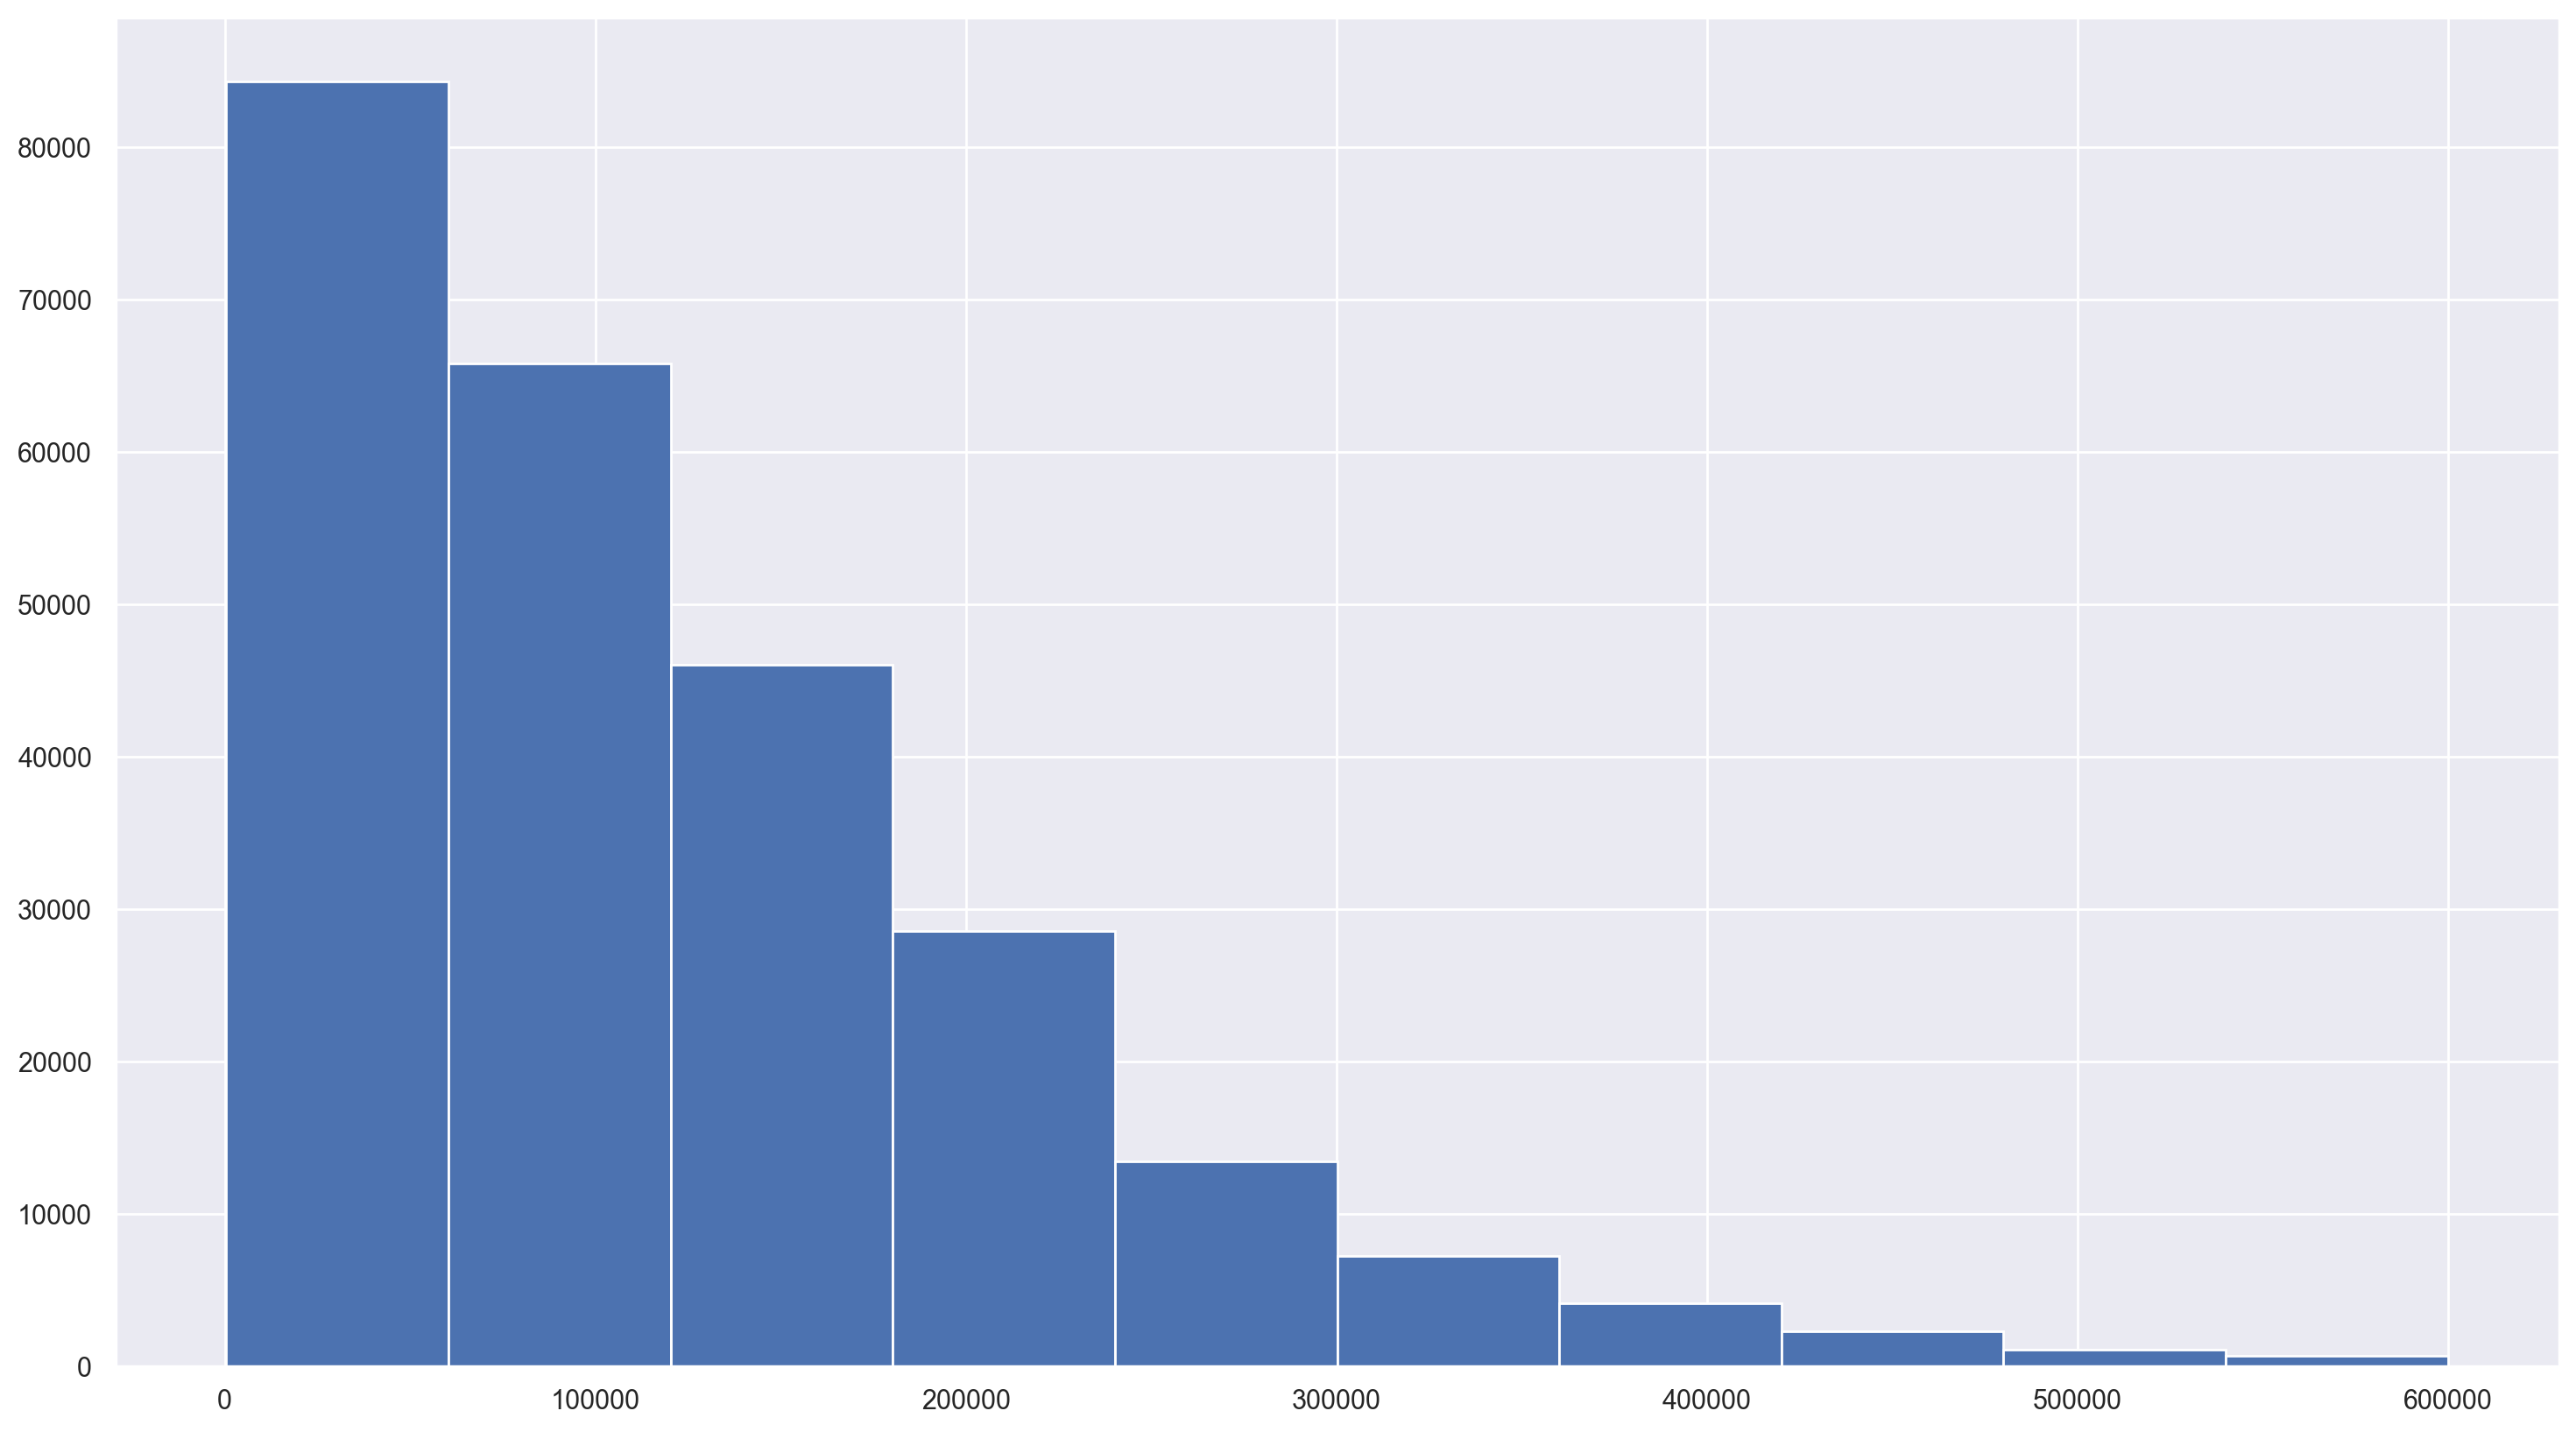

In [199]:
TAD['y'].hist(figsize=(18, 10))

### Partición de los datos

In [200]:
varc = TAD.filter(like='v_').columns.to_list()

In [201]:
X_train, X_valid, y_train, y_valid = train_test_split(TAD[varc], TAD['y'], train_size=0.75)

In [202]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((190119, 3), (63373, 3), (190119,), (63373,))

### Entrenamiento: Regresión

In [203]:
model_r = LinearRegression(n_jobs=-1)
model_r

LinearRegression(n_jobs=-1)

In [204]:
model_r.fit( X_train, y_train )

LinearRegression(n_jobs=-1)

#### Parametros del modelo

In [205]:
model_r.intercept_, model_r.coef_

(np.float64(6057.3392684690625),
 array([ 7.56221352e-01, -1.01301655e+04,  1.79356250e-01]))

#### Evaluación del modelo

In [206]:
mean_absolute_error( y_pred=model_r.predict(X_train), y_true=y_train )

26385.66508728881

In [207]:
mean_absolute_error( y_pred=model_r.predict(X_valid), y_true=y_valid )

26345.865799419706

#### Visualizaciones

(array([21054., 16460., 11399.,  7207.,  3337.,  1842.,  1032.,   635.,
          243.,   164.]),
 array([4.05000e+02, 6.03440e+04, 1.20283e+05, 1.80222e+05, 2.40161e+05,
        3.00100e+05, 3.60039e+05, 4.19978e+05, 4.79917e+05, 5.39856e+05,
        5.99795e+05]),
 <BarContainer object of 10 artists>)

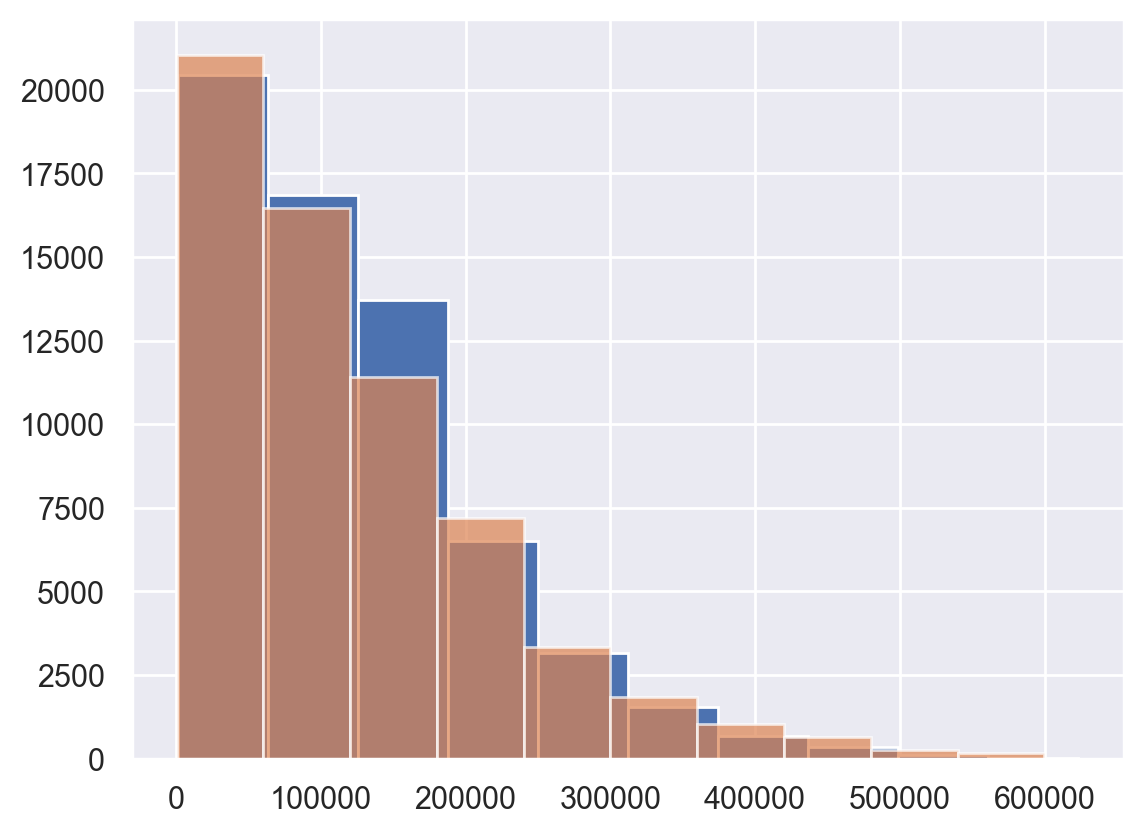

In [208]:
plt.hist( model_r.predict(X_valid))
plt.hist( y_valid , alpha=0.7)

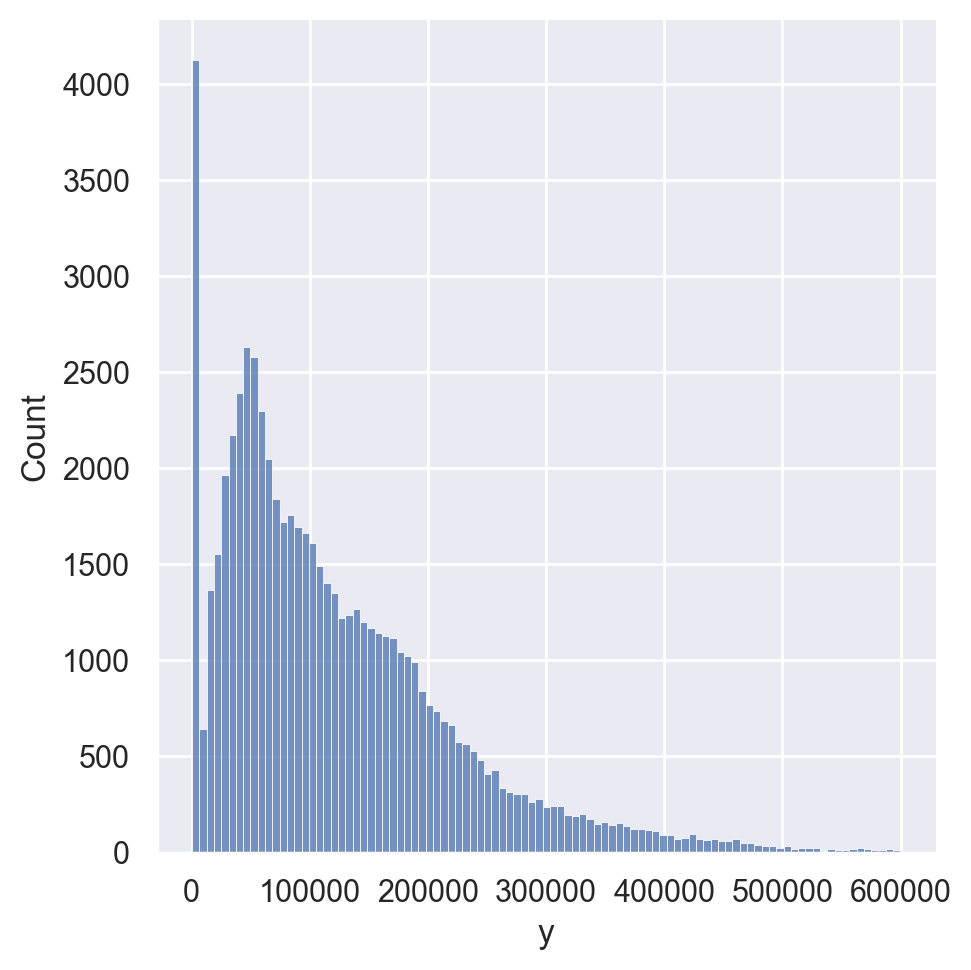

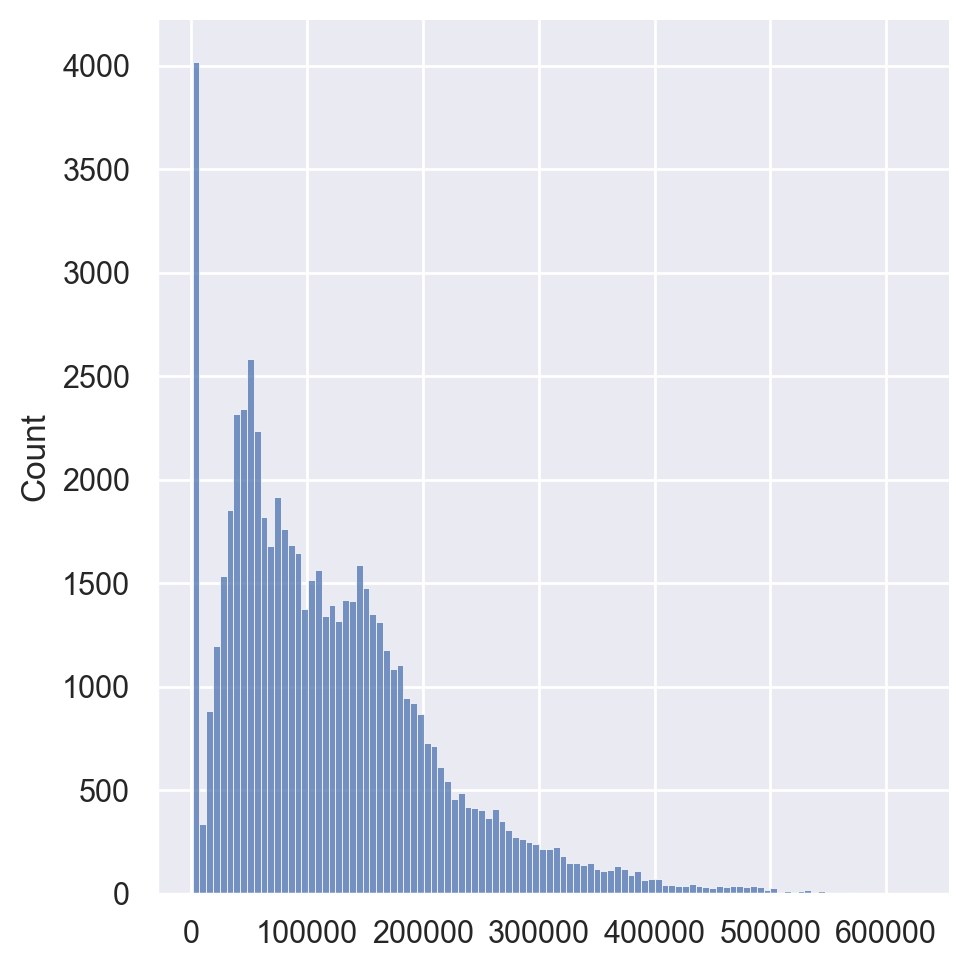

In [209]:
sns.displot( y_valid, kde_kws={'cumulative':True} )
sns.displot( model_r.predict( X_valid[varc] ), kde_kws={'cumulative':True} , )

In [210]:
X_valid['y'] = y_valid
X_valid['y^'] = model_r.predict( X_valid[varc] )

In [211]:
X_valid['error'] = X_valid['y'] - X_valid['y^']
X_valid

,v_max_afluencia,v_pct_delta_desv_afluencia,v_delta_mean_afluencia,y,y^,error
218389,"26,274.000000",0.366323,305.222222,"21,840.000000","22,270.130840",-430.130840
111687,"63,078.000000",0.314187,"3,677.555556","42,785.000000","51,235.099778","-8,450.099778"
250637,"18,896.000000",0.536589,62.777778,"15,903.000000","14,922.421877",980.578123
5571,"71,796.000000",0.350202,795.666667,"49,844.000000","56,946.113875","-7,102.113875"
56226,"185,540.000000",0.147840,"-2,247.111111","128,729.000000","144,465.969211","-15,736.969211"
...,...,...,...,...,...,...
225728,"25,805.000000",0.384975,384.666667,"21,010.000000","21,740.767877",-730.767877
229933,"237,135.000000",0.700971,"1,426.555556","221,548.000000","178,538.801954","43,009.198046"
249936,"440,944.000000",0.476363,"16,878.666667","393,449.000000","337,710.263735","55,738.736265"
119794,"66,091.000000",0.235493,"1,561.777778","23,445.000000","53,931.296312","-30,486.296312"


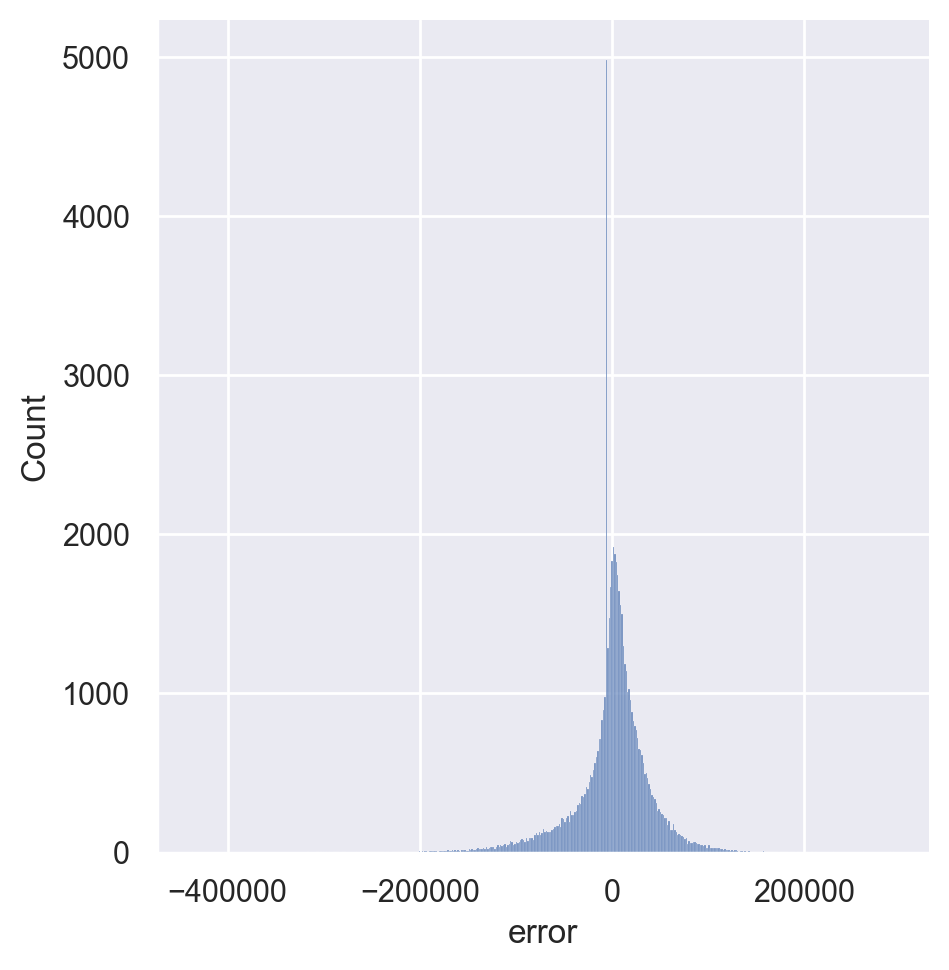

In [212]:
sns.displot( X_valid['error'], kde_kws={'cumulative':True} )

<Axes: >

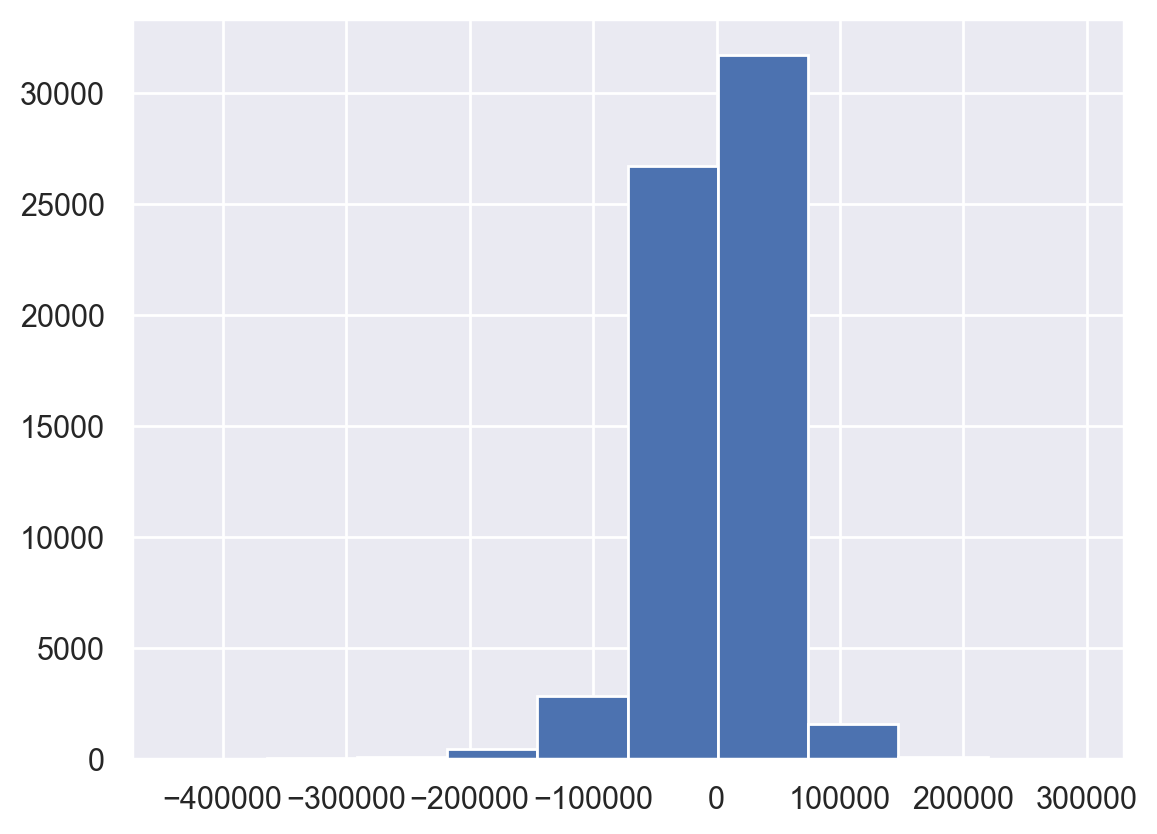

In [213]:
X_valid['error'].hist()

In [214]:
X_valid['error'].describe( percentiles=np.arange(0, 1.01, .1) )

count     63,373.000000
mean           5.421080
std       40,291.799433
min     -437,360.895313
0%      -437,360.895313
10%      -44,993.361081
20%      -17,985.884539
30%       -5,958.608916
40%       -3,042.246296
50%        2,256.963284
60%        7,519.867341
70%       14,242.293517
80%       24,160.266853
90%       40,528.042771
100%     293,169.982227
max      293,169.982227
Name: error, dtype: float64

## Modelo 2: Clasificación

In [215]:
TAD_ = pd.read_parquet("../data/output/TAD_02_ESTACIONES.parquet")
TAD_

,id_estacion,ancla,v_max_afluencia,v_pct_delta_desv_afluencia,v_delta_mean_afluencia,y2
0,Est00000,10,"257,761.000000",1.235866,"12,839.222222",1
1,Est00002,10,"54,652.000000",0.641499,21.222222,1
2,Est00003,10,"253,680.000000",1.442348,"7,721.444444",1
3,Est00004,10,"255,863.000000",0.407847,307.555556,1
4,Est00005,10,"18,637.000000",0.290186,-276.555556,1
...,...,...,...,...,...,...
254191,Est00385,699,405.000000,0.000000,0.000000,0
254192,Est00386,699,"71,912.000000",0.370158,198.777778,1
254193,Est00387,699,"336,441.000000",0.090890,"3,205.222222",1
254194,Est00388,699,"280,277.000000",0.350651,"13,233.666667",1


<Axes: xlabel='y2'>

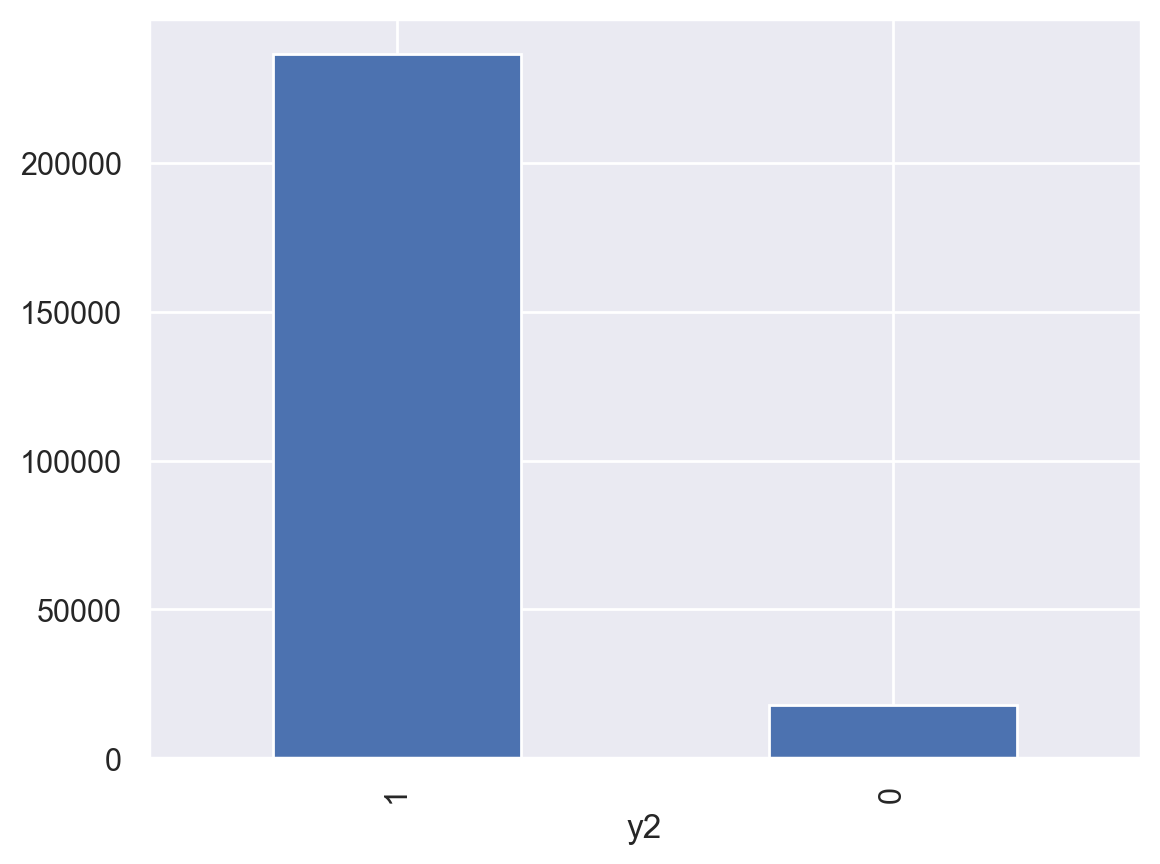

In [216]:
TAD_['y2'].value_counts().plot(kind='bar')

In [217]:
varc = TAD_.filter(like='v_').columns.to_list()

X = TAD_[varc]
y = TAD_['y2']

### Particion de los datos 

In [218]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((190647, 3), (63549, 3), (190647,), (63549,))

### Entrenamiento: Regresión Logistica 

In [219]:
modelo_c = LogisticRegression(n_jobs=-1)

In [220]:
modelo_c.fit(X_train, y_train)

LogisticRegression(n_jobs=-1)

In [221]:
modelo_c.coef_, modelo_c.intercept_

(array([[ 0.00021286, -0.13517139,  0.00040626]]), array([-3.12627357]))

### Evaluación del modelo

In [222]:
pd.DataFrame( modelo_c.predict_proba( X_valid ) )

,0,1
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000204,0.999796
3,0.000000,1.000000
4,0.000000,1.000000
...,...,...
63544,0.000000,1.000000
63545,0.000000,1.000000
63546,0.954352,0.045648
63547,0.000000,1.000000


In [223]:
X_valid['y2^'] = pd.DataFrame( modelo_c.predict( X_valid ) )
X_valid

,v_max_afluencia,v_pct_delta_desv_afluencia,v_delta_mean_afluencia,y2^
53967,"131,286.000000",0.346717,"-4,060.666667",1.000000
249460,"106,866.000000",0.182141,"3,405.444444",NaN
952,"53,415.000000",0.540111,806.333333,1.000000
63246,"183,160.000000",0.598775,"-2,229.777778",1.000000
46452,"119,317.000000",0.408069,"2,683.111111",1.000000
...,...,...,...,...
33979,"171,579.000000",1.079917,"-8,888.888889",1.000000
241340,"157,577.000000",0.707736,"1,923.000000",NaN
92691,405.000000,0.000000,0.000000,NaN
169056,"371,212.000000",0.328185,"-4,256.222222",NaN


<Axes: xlabel='y2^'>

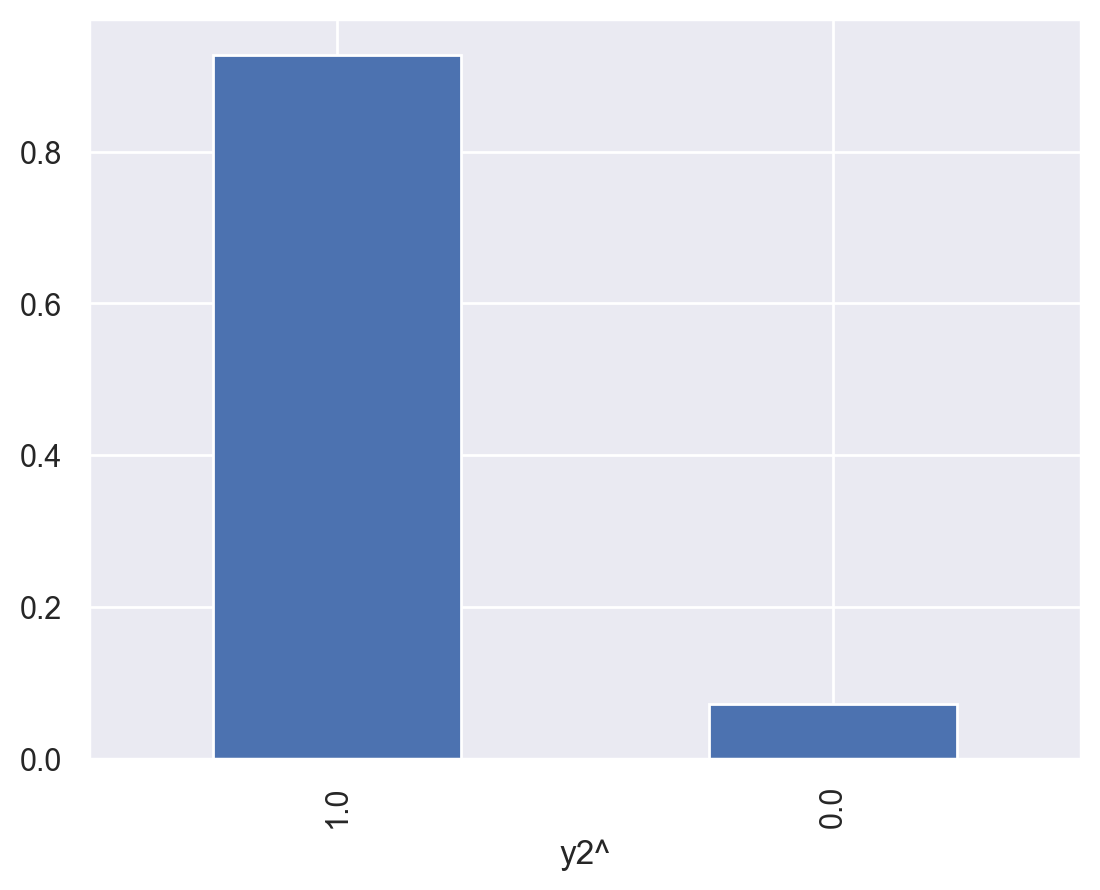

In [224]:
X_valid['y2^'].value_counts(1).plot(kind='bar')

In [225]:
X_valid['y2'] = y_valid
X_valid

,v_max_afluencia,v_pct_delta_desv_afluencia,v_delta_mean_afluencia,y2^,y2
53967,"131,286.000000",0.346717,"-4,060.666667",1.000000,1
249460,"106,866.000000",0.182141,"3,405.444444",NaN,1
952,"53,415.000000",0.540111,806.333333,1.000000,1
63246,"183,160.000000",0.598775,"-2,229.777778",1.000000,1
46452,"119,317.000000",0.408069,"2,683.111111",1.000000,1
...,...,...,...,...,...
33979,"171,579.000000",1.079917,"-8,888.888889",1.000000,1
241340,"157,577.000000",0.707736,"1,923.000000",NaN,1
92691,405.000000,0.000000,0.000000,NaN,0
169056,"371,212.000000",0.328185,"-4,256.222222",NaN,1


<Axes: xlabel='y2'>

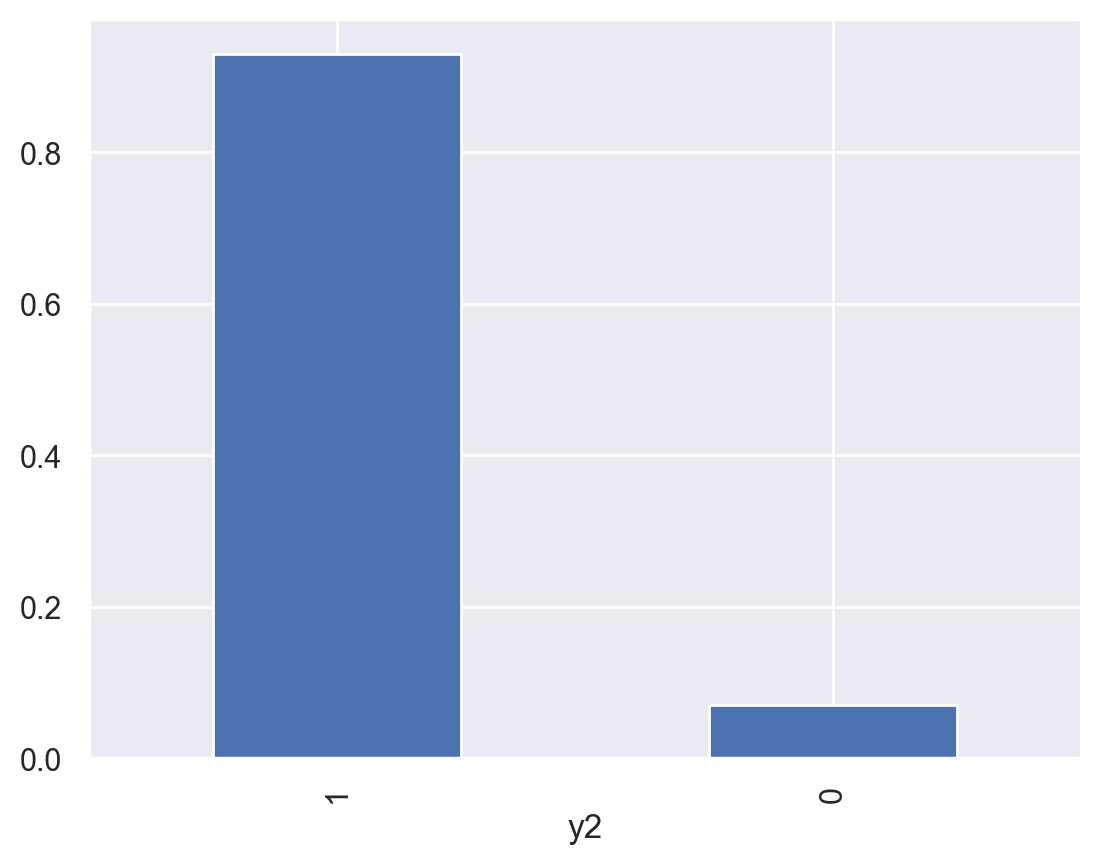

In [226]:
X_valid['y2'].value_counts(1).plot(kind='bar')

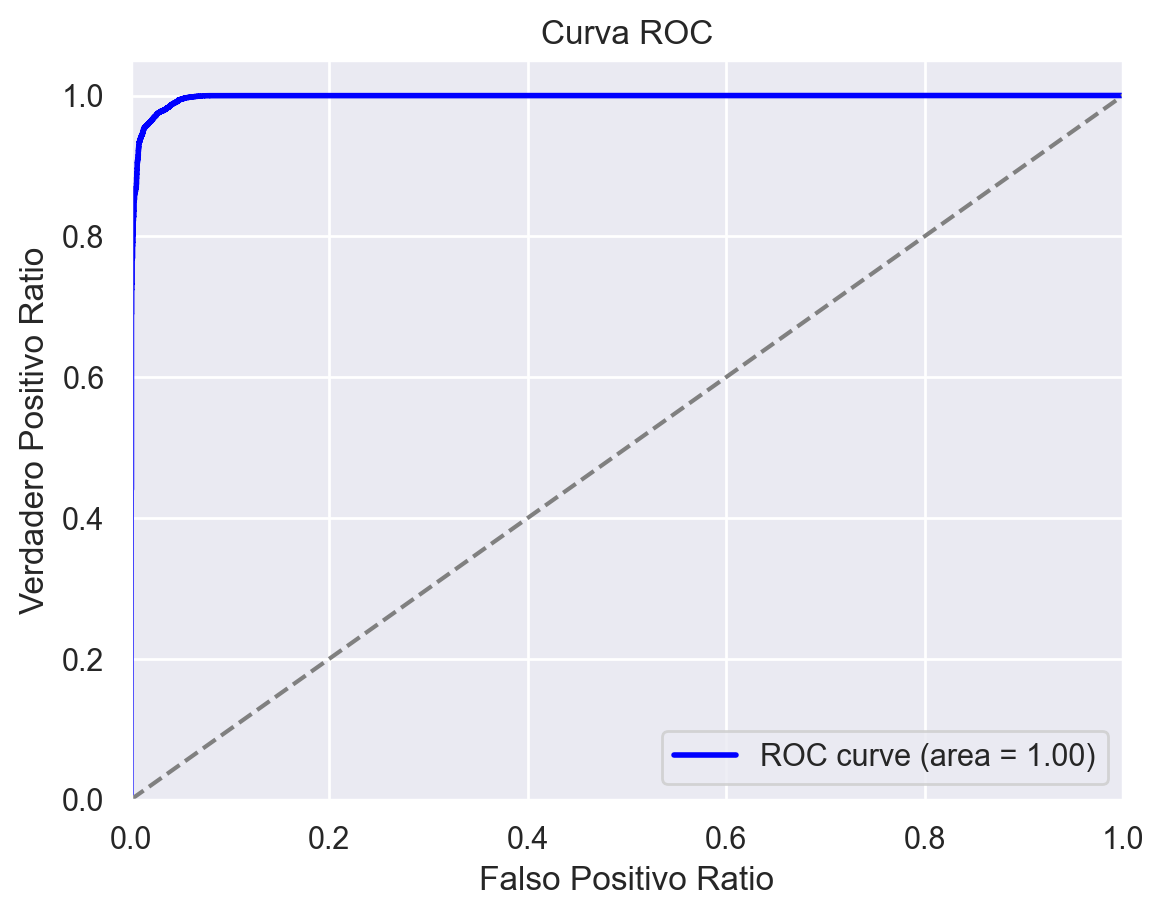

In [227]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = y_valid
y_scores = modelo_c.predict_proba( X_valid[varc] )[:, 1]

# Calcular la curva de ROC
fpr, tpr, _ = roc_curve( y_true=y_true, y_score=y_scores )
roc_auc = auc( fpr, tpr )

# Graficar
plt.figure()
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Falso Positivo Ratio")
plt.ylabel("Verdadero Positivo Ratio")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

In [228]:
def metricas(model,Xv,yv):
    print(" Métricas para modelo de clasificación: \n")

    print(" Valor ROC : %.3f"   %roc_auc_score( y_score=model.predict_proba(Xv)[:,1] , y_true=yv  )   )

    print(" Valor ACC : %.3f\n" %accuracy_score( y_pred=model.predict(Xv) , y_true=yv) )

    print(" Matriz de confusión: ", "\n", confusion_matrix(y_pred=model.predict(Xv) , y_true=yv ) )

In [229]:
metricas(modelo_c , X_valid[varc], y_valid)

 Métricas para modelo de clasificación: 

 Valor ROC : 0.997
 Valor ACC : 0.993

 Matriz de confusión:  
 [[ 4238   257]
 [  174 58880]]
